# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']))#, 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
# the [20:-1] portion simply removes the filepath and folder number
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [3]:
train_files.shape

(6680,)

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


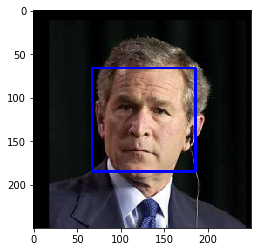

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[5])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

The algorithm finds human faces in 99% of the human subset and 12% of the dog subset

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_found = 0
dogman_found = 0
for img_path in human_files_short:
    if face_detector(img_path):
        human_found += 1

for img_path in dog_files_short:
    if face_detector(img_path):
        dogman_found += 1
        
print(f'Found {human_found} faces in the human dataset')
print(f'Found {dogman_found} faces in the dog dataset')


Found 99 faces in the human dataset
Found 12 faces in the dog dataset


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [8]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

1% of the photos in the human dataset have a detected dog; 100% of the photos in the dog dataset have a detected dog.

In [13]:
# Following block is neccessary to utilize GPU
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_detected_dog_short = 0
dog_detected_human_short = 0

for img_path in human_files_short:
    if dog_detector(img_path):
        dog_detected_human_short += 1

for img_path in dog_files_short:
    if dog_detector(img_path):
        dog_detected_dog_short += 1
        
print(f'Found {dog_detected_human_short} dogs in the human dataset')
print(f'Found {dog_detected_dog_short} dogs in the dog dataset')

Found 1 dogs in the human dataset
Found 100 dogs in the dog dataset


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_ !), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████| 836/836 [00:05<00:00, 141.11it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [15]:
train_tensors[0].shape

(224, 224, 3)

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

# Define your architecture.
model.add(Conv2D(16, kernel_size=2, activation='relu', input_shape=(224,224,3))) # activation nonlinearity typically performed before pooling
model.add(MaxPooling2D()) # defaults to pool_size = (2,2), stride = None = pool_size
model.add(Conv2D(32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10370004969066181242
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2080443140667105873
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [19]:
from keras.callbacks import ModelCheckpoint  

# specify the number of epochs that you would like to use to train the model.

epochs = 3

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/3
 - 8s - loss: 4.8854 - acc: 0.0081 - val_loss: 4.8697 - val_acc: 0.0108

Epoch 00001: val_loss improved from inf to 4.86967, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/3
 - 8s - loss: 4.8573 - acc: 0.0141 - val_loss: 4.8377 - val_acc: 0.0156

Epoch 00002: val_loss improved from 4.86967 to 4.83769, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/3
 - 8s - loss: 4.8092 - acc: 0.0177 - val_loss: 4.8074 - val_acc: 0.0168

Epoch 00003: val_loss improved from 4.83769 to 4.80737, saving model to saved_models/weights.best.from_scratch.hdf5


### Load the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.6746%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [23]:
train_VGG16.shape

(6680, 7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [24]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [25]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [26]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 2:47 - loss: 15.3356 - acc: 0.05 - ETA: 11s - loss: 14.4584 - acc: 0.0200 - ETA: 5s - loss: 14.1699 - acc: 0.030 - ETA: 3s - loss: 13.9988 - acc: 0.03 - ETA: 2s - loss: 13.8500 - acc: 0.03 - ETA: 2s - loss: 13.6995 - acc: 0.04 - ETA: 1s - loss: 13.5964 - acc: 0.04 - ETA: 1s - loss: 13.4494 - acc: 0.05 - ETA: 1s - loss: 13.2402 - acc: 0.06 - ETA: 1s - loss: 13.0985 - acc: 0.07 - ETA: 0s - loss: 13.0102 - acc: 0.07 - ETA: 0s - loss: 12.9271 - acc: 0.08 - ETA: 0s - loss: 12.8374 - acc: 0.09 - ETA: 0s - loss: 12.7149 - acc: 0.10 - ETA: 0s - loss: 12.6553 - acc: 0.10 - ETA: 0s - loss: 12.5585 - acc: 0.10 - ETA: 0s - loss: 12.4965 - acc: 0.11 - ETA: 0s - loss: 12.4430 - acc: 0.11 - ETA: 0s - loss: 12.3927 - acc: 0.11 - 2s 243us/step - loss: 12.3550 - acc: 0.1189 - val_loss: 10.8724 - val_acc: 0.2168

Epoch 00001: val_loss improved from inf to 10.87242, saving model to saved_models/weig

6680/6680 [==============================] - ETA: 1s - loss: 5.6513 - acc: 0.650 - ETA: 0s - loss: 7.9709 - acc: 0.491 - ETA: 0s - loss: 8.0477 - acc: 0.482 - ETA: 0s - loss: 8.1245 - acc: 0.476 - ETA: 0s - loss: 7.9843 - acc: 0.483 - ETA: 0s - loss: 7.9446 - acc: 0.486 - ETA: 0s - loss: 7.8347 - acc: 0.492 - ETA: 0s - loss: 7.9440 - acc: 0.483 - ETA: 0s - loss: 7.9887 - acc: 0.478 - ETA: 0s - loss: 7.9098 - acc: 0.482 - ETA: 0s - loss: 7.9793 - acc: 0.477 - ETA: 0s - loss: 7.8937 - acc: 0.483 - ETA: 0s - loss: 7.9101 - acc: 0.481 - ETA: 0s - loss: 7.9120 - acc: 0.481 - ETA: 0s - loss: 7.8565 - acc: 0.484 - ETA: 0s - loss: 7.8075 - acc: 0.487 - ETA: 0s - loss: 7.8503 - acc: 0.484 - ETA: 0s - loss: 7.8589 - acc: 0.484 - ETA: 0s - loss: 7.8597 - acc: 0.484 - 1s 157us/step - loss: 7.8664 - acc: 0.4837 - val_loss: 8.4136 - val_acc: 0.3856

Epoch 00009: val_loss improved from 8.62487 to 8.41359, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 10/20
6680/6680 [====================

6680/6680 [==============================] - ETA: 0s - loss: 5.6466 - acc: 0.650 - ETA: 1s - loss: 7.1217 - acc: 0.552 - ETA: 0s - loss: 6.7761 - acc: 0.567 - ETA: 0s - loss: 6.7224 - acc: 0.570 - ETA: 0s - loss: 6.7990 - acc: 0.565 - ETA: 0s - loss: 6.5863 - acc: 0.576 - ETA: 0s - loss: 6.5318 - acc: 0.580 - ETA: 0s - loss: 6.4623 - acc: 0.585 - ETA: 0s - loss: 6.4768 - acc: 0.584 - ETA: 0s - loss: 6.4489 - acc: 0.586 - ETA: 0s - loss: 6.3794 - acc: 0.589 - ETA: 0s - loss: 6.3990 - acc: 0.589 - ETA: 0s - loss: 6.3739 - acc: 0.591 - ETA: 0s - loss: 6.3169 - acc: 0.594 - ETA: 0s - loss: 6.3454 - acc: 0.592 - ETA: 0s - loss: 6.2860 - acc: 0.595 - ETA: 0s - loss: 6.2932 - acc: 0.595 - ETA: 0s - loss: 6.3056 - acc: 0.595 - ETA: 0s - loss: 6.3482 - acc: 0.592 - 1s 155us/step - loss: 6.3780 - acc: 0.5915 - val_loss: 7.2336 - val_acc: 0.4635

Epoch 00017: val_loss improved from 7.23436 to 7.23359, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 18/20
6680/6680 [====================

### Load the Model with the Best Validation Loss

In [27]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [28]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.4450%


### Predict Dog Breed with the Model

In [29]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [47]:
# Obtain bottleneck features from another pre-trained CNN.

# function to test a network
networks = ['VGG19', 'ResNet50', 'InceptionV3', 'Xception']

def xfer_net_tester(network_name):
    print(f'testing network: {network}')
    
    # get bottleneck features
    print('\tgetting bottleneck features...')
    bottleneck_features = np.load(f'bottleneck_features/Dog{network}Data.npz')
    
    # translate read-in features into test-train-validate
    train_bottle = bottleneck_features['train']
    valid_bottle = bottleneck_features['valid']
    test_bottle = bottleneck_features['test']
    
    # compile our own output sigmoids
    print('\tcompiling custom output nodes...')
    xfer_model = Sequential()
    xfer_model.add(GlobalAveragePooling2D(input_shape=train_bottle.shape[1:]))
    xfer_model.add(Dense(133, activation='softmax'))

    #xfer_model.summary()
    xfer_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    print('\ttraining model...')
    checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.{network}.hdf5', 
                               verbose=1, save_best_only=True)

    xfer_model.fit(train_bottle, train_targets, 
          validation_data=(valid_bottle, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)
    
    # load best model
    print('\tloading best model...')
    xfer_model.load_weights(f'saved_models/weights.best.{network}.hdf5')
    
    # get index of predicted dog breed for each image in test set
    print('\ttesting model...')
    xfer_predictions = [np.argmax(xfer_model.predict(np.expand_dims(feature, axis=0))) for feature in test_bottle]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(xfer_predictions)==np.argmax(test_targets, axis=1))/len(xfer_predictions)
    
    print('{} Test accuracy: {:.4f}'.format(network, test_accuracy))
    return test_accuracy
    
n_accs = []
for network in networks:
    n_acc = xfer_net_tester(network)
    n_accs.append((network, n_acc))

print(n_accs)
            

testing network: VGG19
	getting bottleneck features...
	compiling custom output nodes...
	training model...
Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 2s - loss: 11.5839 - acc: 0.1473 - val_loss: 9.8418 - val_acc: 0.2515

Epoch 00001: val_loss improved from inf to 9.84184, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 2/20
 - 1s - loss: 8.8813 - acc: 0.3310 - val_loss: 8.8034 - val_acc: 0.3341

Epoch 00002: val_loss improved from 9.84184 to 8.80335, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 3/20
 - 1s - loss: 8.1341 - acc: 0.4133 - val_loss: 8.4515 - val_acc: 0.3868

Epoch 00003: val_loss improved from 8.80335 to 8.45153, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 4/20
 - 1s - loss: 7.8852 - acc: 0.4545 - val_loss: 8.2301 - val_acc: 0.4060

Epoch 00004: val_loss improved from 8.45153 to 8.23007, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 5/20
 - 1s - loss: 7.4923 - acc: 0.4820 - val_loss: 7.7915 - val_acc: 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [247]:
# Define your architecture.
# it appears that the Xception model performs the best

from keras.callbacks import History 
history = History()

#net = 'Xception' # too much entropic capacity - memorized models with its parameters
net = 'ResNet50'
#net = 'VGG19'
#net = 'InceptionV3'

# get bottleneck features
bottleneck_features = np.load(f'bottleneck_features/Dog{net}Data.npz')

# translate read-in features into test-train-validate
train_bottle = bottleneck_features['train']
valid_bottle = bottleneck_features['valid']
test_bottle = bottleneck_features['test']

In [248]:
# define custom model architecture 1
custom_model = Sequential()
custom_model.add(GlobalAveragePooling2D(input_shape=train_bottle.shape[1:]))
custom_model.add(Dense(133, activation='softmax'))

custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [307]:
train_bottle.shape[1:]

(1, 1, 2048)

In [249]:
# define custom model architecture 2
from keras import regularizers

custom_model = Sequential()
#custom_model.add(Flatten(input_shape=train_bottle.shape[1:]))
custom_model.add(GlobalAveragePooling2D(input_shape = train_bottle.shape[1:]))
custom_model.add(Dense(512,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.02)))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(256,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.02)))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(133, activation='softmax'))

custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 133)               34181     
Total params: 1,214,597
Trainable params: 1,214,597
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [250]:
# Compile the model.
from keras import optimizers

#custom_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
custom_model.compile(loss='categorical_crossentropy',
                     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                     metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [251]:
%%time

# Train the model.

print('training model...')
checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.{net}.hdf5', 
                           verbose=1, save_best_only=True)

custom_model.fit(train_bottle, train_targets, 
      validation_data=(valid_bottle, valid_targets),
      epochs=500, batch_size=20, callbacks=[checkpointer, history], verbose=2)

training model...
Train on 6680 samples, validate on 835 samples
Epoch 1/500
 - 9s - loss: 28.1395 - acc: 0.0106 - val_loss: 27.3456 - val_acc: 0.0299

Epoch 00001: val_loss improved from inf to 27.34562, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 2/500
 - 2s - loss: 27.1949 - acc: 0.0172 - val_loss: 26.6632 - val_acc: 0.0575

Epoch 00002: val_loss improved from 27.34562 to 26.66321, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 3/500
 - 2s - loss: 26.4956 - acc: 0.0240 - val_loss: 26.0166 - val_acc: 0.1042

Epoch 00003: val_loss improved from 26.66321 to 26.01658, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 4/500
 - 2s - loss: 25.8308 - acc: 0.0350 - val_loss: 25.3818 - val_acc: 0.1665

Epoch 00004: val_loss improved from 26.01658 to 25.38175, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 5/500
 - 2s - loss: 25.2011 - acc: 0.0461 - val_loss: 24.7586 - val_acc: 0.2024

Epoch 00005: val_loss improved from 25.38175 to 2


Epoch 00041: val_loss improved from 9.65526 to 9.43087, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 42/500
 - 2s - loss: 9.9012 - acc: 0.5225 - val_loss: 9.2112 - val_acc: 0.7317

Epoch 00042: val_loss improved from 9.43087 to 9.21123, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 43/500
 - 2s - loss: 9.6880 - acc: 0.5232 - val_loss: 9.0023 - val_acc: 0.7437

Epoch 00043: val_loss improved from 9.21123 to 9.00227, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 44/500
 - 2s - loss: 9.4578 - acc: 0.5376 - val_loss: 8.7985 - val_acc: 0.7425

Epoch 00044: val_loss improved from 9.00227 to 8.79855, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 45/500
 - 2s - loss: 9.2687 - acc: 0.5307 - val_loss: 8.6075 - val_acc: 0.7485

Epoch 00045: val_loss improved from 8.79855 to 8.60753, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 46/500
 - 2s - loss: 9.0725 - acc: 0.5347 - val_loss: 8.4123 - val_acc: 0.7485

Epoch 000

Epoch 00082: val_loss improved from 4.21286 to 4.14400, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 83/500
 - 2s - loss: 4.4984 - acc: 0.6461 - val_loss: 4.0707 - val_acc: 0.8060

Epoch 00083: val_loss improved from 4.14400 to 4.07066, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 84/500
 - 2s - loss: 4.4291 - acc: 0.6463 - val_loss: 4.0056 - val_acc: 0.7976

Epoch 00084: val_loss improved from 4.07066 to 4.00564, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 85/500
 - 2s - loss: 4.3792 - acc: 0.6332 - val_loss: 3.9438 - val_acc: 0.8012

Epoch 00085: val_loss improved from 4.00564 to 3.94384, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 86/500
 - 2s - loss: 4.2838 - acc: 0.6524 - val_loss: 3.8794 - val_acc: 0.8012

Epoch 00086: val_loss improved from 3.94384 to 3.87942, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 87/500
 - 2s - loss: 4.2193 - acc: 0.6548 - val_loss: 3.8171 - val_acc: 0.8048

Epoch 0008

Epoch 00123: val_loss improved from 2.42019 to 2.39483, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 124/500
 - 2s - loss: 2.6609 - acc: 0.7000 - val_loss: 2.3695 - val_acc: 0.8204

Epoch 00124: val_loss improved from 2.39483 to 2.36947, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 125/500
 - 2s - loss: 2.6661 - acc: 0.6949 - val_loss: 2.3495 - val_acc: 0.8240

Epoch 00125: val_loss improved from 2.36947 to 2.34953, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 126/500
 - 2s - loss: 2.6223 - acc: 0.6924 - val_loss: 2.3233 - val_acc: 0.8263

Epoch 00126: val_loss improved from 2.34953 to 2.32333, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 127/500
 - 2s - loss: 2.6084 - acc: 0.6975 - val_loss: 2.3017 - val_acc: 0.8228

Epoch 00127: val_loss improved from 2.32333 to 2.30166, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 128/500
 - 2s - loss: 2.6009 - acc: 0.6997 - val_loss: 2.2823 - val_acc: 0.8240

Epoch

Epoch 00164: val_loss improved from 1.78082 to 1.77294, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 165/500
 - 2s - loss: 2.0009 - acc: 0.7281 - val_loss: 1.7651 - val_acc: 0.8180

Epoch 00165: val_loss improved from 1.77294 to 1.76506, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 166/500
 - 2s - loss: 2.0027 - acc: 0.7177 - val_loss: 1.7540 - val_acc: 0.8275

Epoch 00166: val_loss improved from 1.76506 to 1.75400, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 167/500
 - 2s - loss: 1.9962 - acc: 0.7123 - val_loss: 1.7476 - val_acc: 0.8204

Epoch 00167: val_loss improved from 1.75400 to 1.74760, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 168/500
 - 2s - loss: 1.9816 - acc: 0.7205 - val_loss: 1.7366 - val_acc: 0.8240

Epoch 00168: val_loss improved from 1.74760 to 1.73656, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 169/500
 - 2s - loss: 1.9787 - acc: 0.7181 - val_loss: 1.7304 - val_acc: 0.8216

Epoch

Epoch 00205: val_loss improved from 1.53008 to 1.52509, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 206/500
 - 2s - loss: 1.7356 - acc: 0.7403 - val_loss: 1.5208 - val_acc: 0.8228

Epoch 00206: val_loss improved from 1.52509 to 1.52080, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 207/500
 - 2s - loss: 1.7216 - acc: 0.7388 - val_loss: 1.5188 - val_acc: 0.8275

Epoch 00207: val_loss improved from 1.52080 to 1.51876, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 208/500
 - 2s - loss: 1.7333 - acc: 0.7394 - val_loss: 1.5150 - val_acc: 0.8287

Epoch 00208: val_loss improved from 1.51876 to 1.51501, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 209/500
 - 2s - loss: 1.7212 - acc: 0.7386 - val_loss: 1.5117 - val_acc: 0.8263

Epoch 00209: val_loss improved from 1.51501 to 1.51171, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 210/500
 - 2s - loss: 1.7173 - acc: 0.7461 - val_loss: 1.5090 - val_acc: 0.8251

Epoch


Epoch 00247: val_loss improved from 1.41431 to 1.41017, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 248/500
 - 2s - loss: 1.5906 - acc: 0.7513 - val_loss: 1.4099 - val_acc: 0.8263

Epoch 00248: val_loss improved from 1.41017 to 1.40985, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 249/500
 - 2s - loss: 1.6040 - acc: 0.7501 - val_loss: 1.4087 - val_acc: 0.8263

Epoch 00249: val_loss improved from 1.40985 to 1.40867, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 250/500
 - 2s - loss: 1.5797 - acc: 0.7542 - val_loss: 1.4067 - val_acc: 0.8275

Epoch 00250: val_loss improved from 1.40867 to 1.40665, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 251/500
 - 2s - loss: 1.5804 - acc: 0.7566 - val_loss: 1.4044 - val_acc: 0.8263

Epoch 00251: val_loss improved from 1.40665 to 1.40437, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 252/500
 - 2s - loss: 1.5798 - acc: 0.7612 - val_loss: 1.4012 - val_acc: 0.8216

Epoc

Epoch 00290: val_loss improved from 1.34707 to 1.34579, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 291/500
 - 2s - loss: 1.5104 - acc: 0.7608 - val_loss: 1.3466 - val_acc: 0.8251

Epoch 00291: val_loss did not improve from 1.34579
Epoch 292/500
 - 2s - loss: 1.5015 - acc: 0.7690 - val_loss: 1.3434 - val_acc: 0.8240

Epoch 00292: val_loss improved from 1.34579 to 1.34342, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 293/500
 - 2s - loss: 1.4955 - acc: 0.7689 - val_loss: 1.3420 - val_acc: 0.8263

Epoch 00293: val_loss improved from 1.34342 to 1.34202, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 294/500
 - 2s - loss: 1.4860 - acc: 0.7728 - val_loss: 1.3389 - val_acc: 0.8287

Epoch 00294: val_loss improved from 1.34202 to 1.33888, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 295/500
 - 2s - loss: 1.4893 - acc: 0.7651 - val_loss: 1.3391 - val_acc: 0.8263

Epoch 00295: val_loss did not improve from 1.33888
Epoch 296/500
 

Epoch 338/500
 - 2s - loss: 1.4386 - acc: 0.7717 - val_loss: 1.2992 - val_acc: 0.8299

Epoch 00338: val_loss did not improve from 1.29853
Epoch 339/500
 - 2s - loss: 1.4197 - acc: 0.7832 - val_loss: 1.2977 - val_acc: 0.8311

Epoch 00339: val_loss improved from 1.29853 to 1.29771, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 340/500
 - 2s - loss: 1.4366 - acc: 0.7756 - val_loss: 1.2984 - val_acc: 0.8287

Epoch 00340: val_loss did not improve from 1.29771
Epoch 341/500
 - 2s - loss: 1.4252 - acc: 0.7805 - val_loss: 1.2975 - val_acc: 0.8275

Epoch 00341: val_loss improved from 1.29771 to 1.29746, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 342/500
 - 2s - loss: 1.4234 - acc: 0.7751 - val_loss: 1.2952 - val_acc: 0.8335

Epoch 00342: val_loss improved from 1.29746 to 1.29524, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 343/500
 - 2s - loss: 1.4331 - acc: 0.7740 - val_loss: 1.2952 - val_acc: 0.8240

Epoch 00343: val_loss improved from 1.29

Epoch 00384: val_loss improved from 1.26824 to 1.26708, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 385/500
 - 2s - loss: 1.3863 - acc: 0.7865 - val_loss: 1.2653 - val_acc: 0.8371

Epoch 00385: val_loss improved from 1.26708 to 1.26526, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 386/500
 - 2s - loss: 1.3869 - acc: 0.7868 - val_loss: 1.2676 - val_acc: 0.8347

Epoch 00386: val_loss did not improve from 1.26526
Epoch 387/500
 - 2s - loss: 1.3852 - acc: 0.7849 - val_loss: 1.2657 - val_acc: 0.8323

Epoch 00387: val_loss did not improve from 1.26526
Epoch 388/500
 - 2s - loss: 1.3813 - acc: 0.7826 - val_loss: 1.2651 - val_acc: 0.8323

Epoch 00388: val_loss improved from 1.26526 to 1.26508, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 389/500
 - 2s - loss: 1.3854 - acc: 0.7873 - val_loss: 1.2622 - val_acc: 0.8335

Epoch 00389: val_loss improved from 1.26508 to 1.26216, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 390/500
 


Epoch 00432: val_loss did not improve from 1.23761
Epoch 433/500
 - 2s - loss: 1.3445 - acc: 0.7928 - val_loss: 1.2389 - val_acc: 0.8287

Epoch 00433: val_loss did not improve from 1.23761
Epoch 434/500
 - 2s - loss: 1.3286 - acc: 0.7907 - val_loss: 1.2403 - val_acc: 0.8275

Epoch 00434: val_loss did not improve from 1.23761
Epoch 435/500
 - 2s - loss: 1.3390 - acc: 0.7988 - val_loss: 1.2391 - val_acc: 0.8311

Epoch 00435: val_loss did not improve from 1.23761
Epoch 436/500
 - 2s - loss: 1.3266 - acc: 0.7969 - val_loss: 1.2385 - val_acc: 0.8335

Epoch 00436: val_loss did not improve from 1.23761
Epoch 437/500
 - 2s - loss: 1.3297 - acc: 0.7958 - val_loss: 1.2361 - val_acc: 0.8347

Epoch 00437: val_loss improved from 1.23761 to 1.23605, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 438/500
 - 2s - loss: 1.3304 - acc: 0.7987 - val_loss: 1.2353 - val_acc: 0.8311

Epoch 00438: val_loss improved from 1.23605 to 1.23527, saving model to saved_models/weights.best.ResNet50.hdf


Epoch 00483: val_loss improved from 1.21715 to 1.21634, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 484/500
 - 2s - loss: 1.3153 - acc: 0.7919 - val_loss: 1.2160 - val_acc: 0.8335

Epoch 00484: val_loss improved from 1.21634 to 1.21601, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 485/500
 - 2s - loss: 1.3001 - acc: 0.7982 - val_loss: 1.2143 - val_acc: 0.8287

Epoch 00485: val_loss improved from 1.21601 to 1.21434, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 486/500
 - 2s - loss: 1.3050 - acc: 0.7970 - val_loss: 1.2153 - val_acc: 0.8287

Epoch 00486: val_loss did not improve from 1.21434
Epoch 487/500
 - 2s - loss: 1.2975 - acc: 0.8045 - val_loss: 1.2134 - val_acc: 0.8323

Epoch 00487: val_loss improved from 1.21434 to 1.21338, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 488/500
 - 2s - loss: 1.2894 - acc: 0.8031 - val_loss: 1.2117 - val_acc: 0.8359

Epoch 00488: val_loss improved from 1.21338 to 1.21166, saving mo

In [252]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


This model achieved a max validation accuracy of 0.8371257471467206


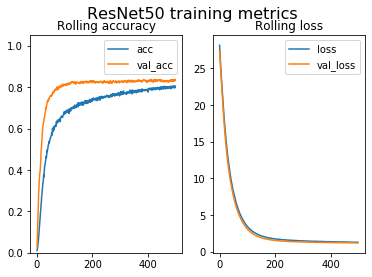

In [253]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(len(history.history['acc']))

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

sns.lineplot(x = epochs, y=history.history['acc'], ax=ax1, label = 'acc')
sns.lineplot(x = epochs, y=history.history['val_acc'], ax=ax1, label = 'val_acc')
ax1.set_ylim(0, 1.05);
ax1.set_title('Rolling accuracy');

sns.lineplot(x = epochs, y=history.history['loss'], ax=ax2, label = 'loss')
sns.lineplot(x = epochs, y=history.history['val_loss'], ax=ax2, label = 'val_loss')
#ax[1].set_ylim(.5, 1.05);
ax2.set_title('Rolling loss');

fig.suptitle(f'{net} training metrics', fontsize = 16);
max_val_acc = max(history.history['val_acc'])
print(f'This model achieved a max validation accuracy of {max_val_acc}')

__note: the use of dropout artificially lowers the training accuracy__

In [254]:
custom_model.load_weights(f'saved_models/weights.best.{net}.hdf5')

# get index of predicted dog breed for each image in test set
custom_predictions = [np.argmax(custom_model.predict(np.expand_dims(feature, axis=0))) for feature in test_bottle]

# report test accuracy
test_accuracy = 100*np.sum(np.array(custom_predictions)==np.argmax(test_targets, axis=1))/len(custom_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 81.4593%


## Custom model layer 1: global average pooling, dense_1; RMSProp optim
### Xception
accuracy and loss was static for both validation and training

### ResNet50
accuracy quickly jumped to near 100 while validation accuracy rose very slightly between .79-.81. Train loss went quickly to 0 while validation loss rose slowly to .8

### VGG19
Over 50 epochs, accuracy climbed from .7 - .8, val acc climbed for the first 30 epochs slightly but stagnated. Loss and val loss both dropped steadily to 3.5 and 5 respectively.

## Custom model layer 2: Flatten, dense_1, dropout, dense_2; SGD optim
### ResNet50
Over 250 epochs, val accuracy and accuracy met at .8 around 90 epochs, then accuracy continued to grow while val accuracy stagnated. Loss steadily dropped...

Trying increasing dropout... same results, except accuracy took a full 250 epochs to hit .8

Trying l2 regularization... same results more or less

Trying l1 regularization... failed to learn

### VGG19
Over 250 epochs, accuracy slowly rose to about .7, val accuracy stagnated at about .5. Loss steadily dropped, val loss dropped with diminishing returns

### Xception
25 million parameters training, with full dropout and l2 .01

Over 250 epochs, accuracy continued to rise while validationa accuracy capped at about 85% after just 30 or so epochs.



# From the ground-up bottlenecking and modeling

In [328]:
# training image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import History 

batch_size = 16

# this is the augmentation configuration I will use for training
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

# This is the augmentation configuration I will use for testing/validation... just a rescale
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1./255)

# This is the generator which will read pictures found in my training subset
train_generator = train_datagen.flow_from_directory(
    'dogImages/train',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical')

# This is the generator for calidation data
validation_generator = test_datagen.flow_from_directory(
    'dogImages/valid',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [329]:
# this function is to wrap the train_generator function to preprocess the image for resnet50
def preprocess_augmented(batch_xy):
    from keras.applications.resnet50 import preprocess_input
    return np.array([preprocess_input(x) for x in batch_xy[0]]), batch_xy[1]

In [324]:
x, y = preprocess_augmented(next(train_generator))

In [325]:
x

array([[[[-103.6354  , -116.40818 , -123.23576 ],
         [-103.62815 , -116.39851 , -123.230934],
         [-103.620895, -116.38885 , -123.22902 ],
         ...,
         [-103.63129 , -116.43991 , -123.226036],
         [-103.61308 , -116.42084 , -123.20158 ],
         [-103.596054, -116.40076 , -123.16999 ]],

        [[-103.66213 , -116.435455, -123.26195 ],
         [-103.63606 , -116.40907 , -123.23621 ],
         [-103.628815, -116.39941 , -123.23138 ],
         ...,
         [-103.62257 , -116.43119 , -123.215576],
         [-103.60436 , -116.41038 , -123.18589 ],
         [-103.59083 , -116.39553 , -123.15779 ]],

        [[-103.68733 , -116.46066 , -123.287155],
         [-103.6648  , -116.43813 , -123.264626],
         [-103.636734, -116.40996 , -123.23666 ],
         ...,
         [-103.61385 , -116.42176 , -123.202965],
         [-103.59652 , -116.40122 , -123.171074],
         [-103.58606 , -116.39076 , -123.14713 ]],

        ...,

        [[-103.762535, -116.535225, -1

In [326]:
x_0, y_0 = next(train_generator)
x_0

array([[[[0.05490196, 0.04313726, 0.01568628],
         [0.05490196, 0.04313726, 0.01568628],
         [0.05490196, 0.04313726, 0.01568628],
         ...,
         [0.01722115, 0.01377692, 0.00688846],
         [0.05469282, 0.0429804 , 0.01560785],
         [0.02035167, 0.01695972, 0.00339194]],

        [[0.05490196, 0.04313726, 0.01568628],
         [0.05490196, 0.04313726, 0.01568628],
         [0.05490196, 0.04313726, 0.01568628],
         ...,
         [0.02196685, 0.01752106, 0.00836736],
         [0.04877723, 0.0385437 , 0.0133895 ],
         [0.01591497, 0.01326248, 0.0026525 ]],

        [[0.05490196, 0.04313726, 0.01568628],
         [0.05490196, 0.04313726, 0.01568628],
         [0.05490196, 0.04313726, 0.01568628],
         ...,
         [0.02862189, 0.0226972 , 0.00984626],
         [0.04286163, 0.03410701, 0.01117115],
         [0.01147828, 0.00956523, 0.00191305]],

        ...,

        [[0.882353  , 0.8745099 , 0.8862746 ],
         [0.882353  , 0.8745099 , 0.8862746 ]

In [327]:
x.shape == x_0.shape

True

In [336]:
ground_up_model = Sequential()

print('loading resnet50 base...')
ResNet50_cnn_model = ResNet50(weights='imagenet', include_top=False)

print('building custom dense addon...')
model = Sequential()

model.add(GlobalAveragePooling2D(input_shape = ResNet50_cnn_model.output_shape[1:])) # the [1:] is necessary to allow for automatic batch dimension to be added by keras
model.add(Dense(512,
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(256,
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

print('assembling frankenstein model...')
ground_up_model.add(ResNet50_cnn_model)
ground_up_model.add(model)

for layer in ground_up_model.layers[0].layers:
    layer.trainable = False

print('compiling frankenstein model...')
ground_up_model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])
print('done.')

loading resnet50 base...
building custom dense addon...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_14  (None, 2048)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 133)               34181     
Total params: 1,214,597
Trainable params: 1,214,597
Non-trainable params: 0
__________

In [ ]:
%%timeit
history = History()

print('training model...')
checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.best.groundup_1.hdf5', 
                           verbose=1, save_best_only=True)
ground_up_model.fit_generator(
    train_generator,
    steps_per_epoch = 6680 // batch_size,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = 835 // batch_size,
    callbacks = [checkpointer, history],
    verbose=1)

training model...
Epoch 1/50


201/417 [=============>................] - ETA: 5:02:20 - loss: 29.2558 - acc: 0.0000e+0 - ETA: 2:31:05 - loss: 29.0494 - acc: 0.0000e+0 - ETA: 1:40:39 - loss: 29.0049 - acc: 0.0208    - ETA: 1:15:26 - loss: 28.8635 - acc: 0.015 - ETA: 1:00:18 - loss: 28.7566 - acc: 0.012 - ETA: 50:13 - loss: 28.7678 - acc: 0.0104  - ETA: 43:01 - loss: 28.7092 - acc: 0.008 - ETA: 37:37 - loss: 28.7248 - acc: 0.007 - ETA: 33:25 - loss: 28.7353 - acc: 0.006 - ETA: 30:03 - loss: 28.7539 - acc: 0.006 - ETA: 27:18 - loss: 28.7712 - acc: 0.005 - ETA: 25:00 - loss: 28.7614 - acc: 0.005 - ETA: 23:04 - loss: 28.7328 - acc: 0.004 - ETA: 21:31 - loss: 28.7524 - acc: 0.004 - ETA: 20:17 - loss: 28.7606 - acc: 0.004 - ETA: 19:12 - loss: 28.7350 - acc: 0.003 - ETA: 18:12 - loss: 28.7057 - acc: 0.003 - ETA: 17:17 - loss: 28.6999 - acc: 0.003 - ETA: 16:28 - loss: 28.7011 - acc: 0.003 - ETA: 15:48 - loss: 28.7005 - acc: 0.003 - ETA: 15:08 - loss: 28.7088 - acc: 0.003 - ETA: 14:32 - loss: 28.6974 - acc: 0.002 - ETA: 13:5

406/417 [============================>.] - ETA: 2:18 - loss: 28.3528 - acc: 0.00 - ETA: 2:17 - loss: 28.3517 - acc: 0.00 - ETA: 2:16 - loss: 28.3514 - acc: 0.00 - ETA: 2:15 - loss: 28.3494 - acc: 0.00 - ETA: 2:14 - loss: 28.3476 - acc: 0.00 - ETA: 2:14 - loss: 28.3470 - acc: 0.00 - ETA: 2:13 - loss: 28.3466 - acc: 0.00 - ETA: 2:12 - loss: 28.3444 - acc: 0.00 - ETA: 2:11 - loss: 28.3424 - acc: 0.00 - ETA: 2:10 - loss: 28.3405 - acc: 0.00 - ETA: 2:09 - loss: 28.3404 - acc: 0.00 - ETA: 2:08 - loss: 28.3388 - acc: 0.00 - ETA: 2:08 - loss: 28.3381 - acc: 0.00 - ETA: 2:07 - loss: 28.3359 - acc: 0.00 - ETA: 2:06 - loss: 28.3347 - acc: 0.00 - ETA: 2:05 - loss: 28.3337 - acc: 0.00 - ETA: 2:04 - loss: 28.3328 - acc: 0.00 - ETA: 2:04 - loss: 28.3309 - acc: 0.00 - ETA: 2:03 - loss: 28.3297 - acc: 0.00 - ETA: 2:02 - loss: 28.3266 - acc: 0.00 - ETA: 2:01 - loss: 28.3237 - acc: 0.00 - ETA: 2:01 - loss: 28.3218 - acc: 0.00 - ETA: 2:00 - loss: 28.3188 - acc: 0.00 - ETA: 1:59 - loss: 28.3172 - acc: 0.00

417/417 [==============================] - ETA: 5s - loss: 28.0474 - acc: 0.00 - ETA: 4s - loss: 28.0459 - acc: 0.00 - ETA: 4s - loss: 28.0436 - acc: 0.00 - ETA: 3s - loss: 28.0406 - acc: 0.00 - ETA: 3s - loss: 28.0398 - acc: 0.00 - ETA: 2s - loss: 28.0393 - acc: 0.00 - ETA: 2s - loss: 28.0380 - acc: 0.00 - ETA: 1s - loss: 28.0368 - acc: 0.00 - ETA: 1s - loss: 28.0353 - acc: 0.00 - ETA: 0s - loss: 28.0339 - acc: 0.00 - 247s 591ms/step - loss: 28.0326 - acc: 0.0093 - val_loss: 27.2755 - val_acc: 0.0144

Epoch 00001: val_loss improved from inf to 27.27550, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 2/50


203/417 [=============>................] - ETA: 2:18 - loss: 27.9034 - acc: 0.0000e+ - ETA: 1:25 - loss: 27.7222 - acc: 0.0000e+ - ETA: 1:07 - loss: 27.5966 - acc: 0.0000e+ - ETA: 58s - loss: 27.6039 - acc: 0.0000e+00 - ETA: 53s - loss: 27.5703 - acc: 0.0000e+0 - ETA: 49s - loss: 27.6045 - acc: 0.0000e+0 - ETA: 47s - loss: 27.6103 - acc: 0.0000e+0 - ETA: 45s - loss: 27.5655 - acc: 0.0000e+0 - ETA: 43s - loss: 27.5617 - acc: 0.0000e+0 - ETA: 42s - loss: 27.5338 - acc: 0.0000e+0 - ETA: 41s - loss: 27.4968 - acc: 0.0000e+0 - ETA: 41s - loss: 27.4892 - acc: 0.0052    - ETA: 39s - loss: 27.4868 - acc: 0.009 - ETA: 46s - loss: 27.4863 - acc: 0.008 - ETA: 52s - loss: 27.4805 - acc: 0.008 - ETA: 57s - loss: 27.4674 - acc: 0.007 - ETA: 1:03 - loss: 27.4821 - acc: 0.00 - ETA: 1:07 - loss: 27.4992 - acc: 0.00 - ETA: 1:11 - loss: 27.4874 - acc: 0.00 - ETA: 1:14 - loss: 27.4869 - acc: 0.00 - ETA: 1:17 - loss: 27.4702 - acc: 0.00 - ETA: 1:19 - loss: 27.4573 - acc: 0.00 - ETA: 1:24 - loss: 27.4506 - 

408/417 [============================>.] - ETA: 1:20 - loss: 27.2548 - acc: 0.00 - ETA: 1:19 - loss: 27.2539 - acc: 0.00 - ETA: 1:19 - loss: 27.2537 - acc: 0.00 - ETA: 1:19 - loss: 27.2520 - acc: 0.01 - ETA: 1:18 - loss: 27.2523 - acc: 0.00 - ETA: 1:18 - loss: 27.2514 - acc: 0.00 - ETA: 1:18 - loss: 27.2501 - acc: 0.00 - ETA: 1:17 - loss: 27.2484 - acc: 0.00 - ETA: 1:17 - loss: 27.2473 - acc: 0.00 - ETA: 1:16 - loss: 27.2457 - acc: 0.00 - ETA: 1:16 - loss: 27.2454 - acc: 0.00 - ETA: 1:16 - loss: 27.2451 - acc: 0.00 - ETA: 1:15 - loss: 27.2438 - acc: 0.00 - ETA: 1:15 - loss: 27.2432 - acc: 0.00 - ETA: 1:15 - loss: 27.2416 - acc: 0.00 - ETA: 1:14 - loss: 27.2410 - acc: 0.00 - ETA: 1:14 - loss: 27.2407 - acc: 0.00 - ETA: 1:13 - loss: 27.2405 - acc: 0.00 - ETA: 1:13 - loss: 27.2400 - acc: 0.00 - ETA: 1:13 - loss: 27.2393 - acc: 0.00 - ETA: 1:12 - loss: 27.2389 - acc: 0.00 - ETA: 1:12 - loss: 27.2390 - acc: 0.00 - ETA: 1:12 - loss: 27.2382 - acc: 0.00 - ETA: 1:11 - loss: 27.2369 - acc: 0.00

417/417 [==============================] - ETA: 3s - loss: 27.0516 - acc: 0.00 - ETA: 2s - loss: 27.0504 - acc: 0.00 - ETA: 2s - loss: 27.0490 - acc: 0.00 - ETA: 1s - loss: 27.0481 - acc: 0.00 - ETA: 1s - loss: 27.0469 - acc: 0.00 - ETA: 1s - loss: 27.0459 - acc: 0.00 - ETA: 0s - loss: 27.0446 - acc: 0.00 - ETA: 0s - loss: 27.0437 - acc: 0.00 - 169s 405ms/step - loss: 27.0422 - acc: 0.0099 - val_loss: 26.4736 - val_acc: 0.0208

Epoch 00002: val_loss improved from 27.27550 to 26.47363, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 3/50


204/417 [=============>................] - ETA: 33s - loss: 26.6569 - acc: 0.0000e+0 - ETA: 31s - loss: 26.6068 - acc: 0.0000e+0 - ETA: 32s - loss: 26.7532 - acc: 0.0000e+0 - ETA: 34s - loss: 26.6682 - acc: 0.0000e+0 - ETA: 34s - loss: 26.6698 - acc: 0.0125    - ETA: 35s - loss: 26.6676 - acc: 0.020 - ETA: 35s - loss: 26.6406 - acc: 0.017 - ETA: 35s - loss: 26.6337 - acc: 0.015 - ETA: 35s - loss: 26.6185 - acc: 0.013 - ETA: 35s - loss: 26.6084 - acc: 0.012 - ETA: 35s - loss: 26.6125 - acc: 0.022 - ETA: 35s - loss: 26.6161 - acc: 0.020 - ETA: 43s - loss: 26.6069 - acc: 0.019 - ETA: 1:03 - loss: 26.5980 - acc: 0.01 - ETA: 1:16 - loss: 26.6020 - acc: 0.01 - ETA: 1:22 - loss: 26.5981 - acc: 0.01 - ETA: 1:25 - loss: 26.5848 - acc: 0.01 - ETA: 1:29 - loss: 26.5910 - acc: 0.01 - ETA: 1:31 - loss: 26.5943 - acc: 0.01 - ETA: 1:34 - loss: 26.6006 - acc: 0.01 - ETA: 1:36 - loss: 26.5929 - acc: 0.01 - ETA: 1:38 - loss: 26.5835 - acc: 0.01 - ETA: 1:40 - loss: 26.5785 - acc: 0.01 - ETA: 1:43 - loss:

409/417 [============================>.] - ETA: 1:18 - loss: 26.4134 - acc: 0.01 - ETA: 1:17 - loss: 26.4126 - acc: 0.01 - ETA: 1:17 - loss: 26.4117 - acc: 0.01 - ETA: 1:17 - loss: 26.4109 - acc: 0.01 - ETA: 1:16 - loss: 26.4099 - acc: 0.01 - ETA: 1:16 - loss: 26.4082 - acc: 0.01 - ETA: 1:15 - loss: 26.4076 - acc: 0.01 - ETA: 1:15 - loss: 26.4071 - acc: 0.01 - ETA: 1:15 - loss: 26.4058 - acc: 0.01 - ETA: 1:14 - loss: 26.4038 - acc: 0.01 - ETA: 1:14 - loss: 26.4026 - acc: 0.01 - ETA: 1:14 - loss: 26.4023 - acc: 0.01 - ETA: 1:13 - loss: 26.4007 - acc: 0.01 - ETA: 1:13 - loss: 26.3991 - acc: 0.01 - ETA: 1:13 - loss: 26.3978 - acc: 0.01 - ETA: 1:12 - loss: 26.3971 - acc: 0.01 - ETA: 1:12 - loss: 26.3968 - acc: 0.01 - ETA: 1:12 - loss: 26.3959 - acc: 0.01 - ETA: 1:11 - loss: 26.3951 - acc: 0.01 - ETA: 1:11 - loss: 26.3935 - acc: 0.01 - ETA: 1:11 - loss: 26.3931 - acc: 0.01 - ETA: 1:10 - loss: 26.3922 - acc: 0.01 - ETA: 1:10 - loss: 26.3911 - acc: 0.01 - ETA: 1:10 - loss: 26.3900 - acc: 0.01

417/417 [==============================] - ETA: 2s - loss: 26.2278 - acc: 0.01 - ETA: 2s - loss: 26.2263 - acc: 0.01 - ETA: 1s - loss: 26.2252 - acc: 0.01 - ETA: 1s - loss: 26.2245 - acc: 0.01 - ETA: 1s - loss: 26.2239 - acc: 0.01 - ETA: 0s - loss: 26.2231 - acc: 0.01 - ETA: 0s - loss: 26.2228 - acc: 0.01 - 168s 402ms/step - loss: 26.2221 - acc: 0.0132 - val_loss: 25.7228 - val_acc: 0.0269

Epoch 00003: val_loss improved from 26.47363 to 25.72282, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 4/50


204/417 [=============>................] - ETA: 31s - loss: 25.8884 - acc: 0.0000e+0 - ETA: 32s - loss: 25.7308 - acc: 0.0312    - ETA: 33s - loss: 25.7284 - acc: 0.020 - ETA: 33s - loss: 25.7654 - acc: 0.015 - ETA: 34s - loss: 25.7663 - acc: 0.012 - ETA: 34s - loss: 25.8211 - acc: 0.010 - ETA: 34s - loss: 25.8330 - acc: 0.008 - ETA: 35s - loss: 25.8314 - acc: 0.007 - ETA: 35s - loss: 25.8446 - acc: 0.013 - ETA: 35s - loss: 25.8513 - acc: 0.012 - ETA: 35s - loss: 25.8574 - acc: 0.011 - ETA: 35s - loss: 25.8544 - acc: 0.010 - ETA: 42s - loss: 25.8475 - acc: 0.009 - ETA: 52s - loss: 25.8425 - acc: 0.008 - ETA: 1:00 - loss: 25.8438 - acc: 0.00 - ETA: 1:10 - loss: 25.8495 - acc: 0.00 - ETA: 1:17 - loss: 25.8441 - acc: 0.00 - ETA: 1:24 - loss: 25.8487 - acc: 0.00 - ETA: 1:28 - loss: 25.8448 - acc: 0.00 - ETA: 1:32 - loss: 25.8372 - acc: 0.00 - ETA: 1:34 - loss: 25.8351 - acc: 0.00 - ETA: 1:36 - loss: 25.8368 - acc: 0.00 - ETA: 1:40 - loss: 25.8328 - acc: 0.00 - ETA: 1:42 - loss: 25.8451 - a

409/417 [============================>.] - ETA: 1:19 - loss: 25.6788 - acc: 0.01 - ETA: 1:18 - loss: 25.6773 - acc: 0.01 - ETA: 1:18 - loss: 25.6773 - acc: 0.01 - ETA: 1:17 - loss: 25.6773 - acc: 0.01 - ETA: 1:17 - loss: 25.6761 - acc: 0.01 - ETA: 1:17 - loss: 25.6753 - acc: 0.01 - ETA: 1:16 - loss: 25.6748 - acc: 0.01 - ETA: 1:16 - loss: 25.6740 - acc: 0.01 - ETA: 1:16 - loss: 25.6725 - acc: 0.01 - ETA: 1:15 - loss: 25.6713 - acc: 0.01 - ETA: 1:15 - loss: 25.6706 - acc: 0.01 - ETA: 1:15 - loss: 25.6689 - acc: 0.01 - ETA: 1:15 - loss: 25.6679 - acc: 0.01 - ETA: 1:14 - loss: 25.6666 - acc: 0.01 - ETA: 1:14 - loss: 25.6648 - acc: 0.01 - ETA: 1:13 - loss: 25.6632 - acc: 0.01 - ETA: 1:13 - loss: 25.6618 - acc: 0.01 - ETA: 1:13 - loss: 25.6616 - acc: 0.01 - ETA: 1:12 - loss: 25.6603 - acc: 0.01 - ETA: 1:12 - loss: 25.6589 - acc: 0.01 - ETA: 1:11 - loss: 25.6568 - acc: 0.01 - ETA: 1:11 - loss: 25.6559 - acc: 0.01 - ETA: 1:11 - loss: 25.6546 - acc: 0.01 - ETA: 1:10 - loss: 25.6542 - acc: 0.01

417/417 [==============================] - ETA: 2s - loss: 25.4959 - acc: 0.01 - ETA: 2s - loss: 25.4948 - acc: 0.01 - ETA: 1s - loss: 25.4942 - acc: 0.01 - ETA: 1s - loss: 25.4936 - acc: 0.01 - ETA: 1s - loss: 25.4923 - acc: 0.01 - ETA: 0s - loss: 25.4913 - acc: 0.01 - ETA: 0s - loss: 25.4903 - acc: 0.01 - 170s 407ms/step - loss: 25.4892 - acc: 0.0127 - val_loss: 25.0138 - val_acc: 0.0354

Epoch 00004: val_loss improved from 25.72282 to 25.01376, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 5/50


204/417 [=============>................] - ETA: 29s - loss: 25.0197 - acc: 0.0000e+0 - ETA: 32s - loss: 24.9918 - acc: 0.0938    - ETA: 33s - loss: 25.0313 - acc: 0.062 - ETA: 33s - loss: 25.0587 - acc: 0.078 - ETA: 35s - loss: 25.0953 - acc: 0.062 - ETA: 35s - loss: 25.0737 - acc: 0.062 - ETA: 35s - loss: 25.0462 - acc: 0.053 - ETA: 35s - loss: 25.0788 - acc: 0.046 - ETA: 35s - loss: 25.0858 - acc: 0.048 - ETA: 35s - loss: 25.0726 - acc: 0.043 - ETA: 35s - loss: 25.0673 - acc: 0.039 - ETA: 35s - loss: 25.0940 - acc: 0.041 - ETA: 42s - loss: 25.1030 - acc: 0.038 - ETA: 52s - loss: 25.1203 - acc: 0.035 - ETA: 1:02 - loss: 25.1291 - acc: 0.03 - ETA: 1:13 - loss: 25.1401 - acc: 0.03 - ETA: 1:22 - loss: 25.1294 - acc: 0.03 - ETA: 1:31 - loss: 25.1297 - acc: 0.03 - ETA: 1:37 - loss: 25.1322 - acc: 0.02 - ETA: 1:39 - loss: 25.1316 - acc: 0.02 - ETA: 1:42 - loss: 25.1297 - acc: 0.02 - ETA: 1:44 - loss: 25.1359 - acc: 0.02 - ETA: 1:47 - loss: 25.1363 - acc: 0.02 - ETA: 1:47 - loss: 25.1341 - a

409/417 [============================>.] - ETA: 1:18 - loss: 24.9461 - acc: 0.01 - ETA: 1:18 - loss: 24.9446 - acc: 0.01 - ETA: 1:18 - loss: 24.9439 - acc: 0.01 - ETA: 1:17 - loss: 24.9430 - acc: 0.01 - ETA: 1:17 - loss: 24.9425 - acc: 0.01 - ETA: 1:16 - loss: 24.9414 - acc: 0.01 - ETA: 1:16 - loss: 24.9406 - acc: 0.01 - ETA: 1:16 - loss: 24.9397 - acc: 0.01 - ETA: 1:16 - loss: 24.9387 - acc: 0.01 - ETA: 1:15 - loss: 24.9371 - acc: 0.01 - ETA: 1:15 - loss: 24.9359 - acc: 0.01 - ETA: 1:14 - loss: 24.9346 - acc: 0.01 - ETA: 1:14 - loss: 24.9333 - acc: 0.01 - ETA: 1:14 - loss: 24.9334 - acc: 0.01 - ETA: 1:13 - loss: 24.9344 - acc: 0.01 - ETA: 1:13 - loss: 24.9341 - acc: 0.01 - ETA: 1:12 - loss: 24.9343 - acc: 0.01 - ETA: 1:12 - loss: 24.9336 - acc: 0.01 - ETA: 1:12 - loss: 24.9327 - acc: 0.01 - ETA: 1:11 - loss: 24.9311 - acc: 0.01 - ETA: 1:11 - loss: 24.9308 - acc: 0.01 - ETA: 1:11 - loss: 24.9299 - acc: 0.01 - ETA: 1:10 - loss: 24.9293 - acc: 0.01 - ETA: 1:10 - loss: 24.9283 - acc: 0.01

417/417 [==============================] - ETA: 2s - loss: 24.7812 - acc: 0.01 - ETA: 2s - loss: 24.7803 - acc: 0.01 - ETA: 1s - loss: 24.7792 - acc: 0.01 - ETA: 1s - loss: 24.7783 - acc: 0.01 - ETA: 1s - loss: 24.7778 - acc: 0.01 - ETA: 0s - loss: 24.7771 - acc: 0.01 - ETA: 0s - loss: 24.7763 - acc: 0.01 - 171s 411ms/step - loss: 24.7750 - acc: 0.0175 - val_loss: 24.3241 - val_acc: 0.0464

Epoch 00005: val_loss improved from 25.01376 to 24.32414, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 6/50


204/417 [=============>................] - ETA: 31s - loss: 24.3298 - acc: 0.0000e+0 - ETA: 34s - loss: 24.3732 - acc: 0.0000e+0 - ETA: 37s - loss: 24.4409 - acc: 0.0000e+0 - ETA: 37s - loss: 24.4531 - acc: 0.0156    - ETA: 35s - loss: 24.4603 - acc: 0.012 - ETA: 36s - loss: 24.4030 - acc: 0.010 - ETA: 36s - loss: 24.3820 - acc: 0.017 - ETA: 35s - loss: 24.3850 - acc: 0.015 - ETA: 35s - loss: 24.3898 - acc: 0.013 - ETA: 35s - loss: 24.4050 - acc: 0.012 - ETA: 35s - loss: 24.3871 - acc: 0.017 - ETA: 35s - loss: 24.3706 - acc: 0.020 - ETA: 47s - loss: 24.3674 - acc: 0.019 - ETA: 59s - loss: 24.3685 - acc: 0.017 - ETA: 1:07 - loss: 24.3739 - acc: 0.01 - ETA: 1:17 - loss: 24.3776 - acc: 0.01 - ETA: 1:30 - loss: 24.3735 - acc: 0.01 - ETA: 1:32 - loss: 24.3737 - acc: 0.01 - ETA: 1:35 - loss: 24.3770 - acc: 0.01 - ETA: 1:36 - loss: 24.3794 - acc: 0.01 - ETA: 1:38 - loss: 24.3843 - acc: 0.01 - ETA: 1:39 - loss: 24.3861 - acc: 0.01 - ETA: 1:40 - loss: 24.3902 - acc: 0.01 - ETA: 1:42 - loss: 24.

409/417 [============================>.] - ETA: 1:19 - loss: 24.2570 - acc: 0.01 - ETA: 1:19 - loss: 24.2557 - acc: 0.01 - ETA: 1:18 - loss: 24.2553 - acc: 0.01 - ETA: 1:18 - loss: 24.2543 - acc: 0.01 - ETA: 1:18 - loss: 24.2535 - acc: 0.01 - ETA: 1:17 - loss: 24.2533 - acc: 0.01 - ETA: 1:17 - loss: 24.2522 - acc: 0.01 - ETA: 1:17 - loss: 24.2514 - acc: 0.01 - ETA: 1:16 - loss: 24.2513 - acc: 0.01 - ETA: 1:16 - loss: 24.2504 - acc: 0.01 - ETA: 1:16 - loss: 24.2494 - acc: 0.01 - ETA: 1:15 - loss: 24.2499 - acc: 0.01 - ETA: 1:15 - loss: 24.2488 - acc: 0.01 - ETA: 1:14 - loss: 24.2487 - acc: 0.01 - ETA: 1:14 - loss: 24.2479 - acc: 0.01 - ETA: 1:14 - loss: 24.2473 - acc: 0.01 - ETA: 1:13 - loss: 24.2464 - acc: 0.01 - ETA: 1:13 - loss: 24.2455 - acc: 0.01 - ETA: 1:13 - loss: 24.2454 - acc: 0.01 - ETA: 1:13 - loss: 24.2443 - acc: 0.01 - ETA: 1:12 - loss: 24.2438 - acc: 0.01 - ETA: 1:12 - loss: 24.2425 - acc: 0.01 - ETA: 1:11 - loss: 24.2432 - acc: 0.01 - ETA: 1:11 - loss: 24.2418 - acc: 0.01

417/417 [==============================] - ETA: 2s - loss: 24.0949 - acc: 0.01 - ETA: 2s - loss: 24.0937 - acc: 0.01 - ETA: 1s - loss: 24.0932 - acc: 0.01 - ETA: 1s - loss: 24.0924 - acc: 0.01 - ETA: 1s - loss: 24.0916 - acc: 0.01 - ETA: 0s - loss: 24.0905 - acc: 0.01 - ETA: 0s - loss: 24.0893 - acc: 0.01 - 171s 409ms/step - loss: 24.0886 - acc: 0.0180 - val_loss: 23.6556 - val_acc: 0.0623

Epoch 00006: val_loss improved from 24.32414 to 23.65555, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 7/50


204/417 [=============>................] - ETA: 31s - loss: 23.7543 - acc: 0.062 - ETA: 34s - loss: 23.7219 - acc: 0.062 - ETA: 33s - loss: 23.7677 - acc: 0.041 - ETA: 36s - loss: 23.7883 - acc: 0.031 - ETA: 38s - loss: 23.8315 - acc: 0.025 - ETA: 37s - loss: 23.8236 - acc: 0.020 - ETA: 36s - loss: 23.8150 - acc: 0.017 - ETA: 37s - loss: 23.8058 - acc: 0.015 - ETA: 37s - loss: 23.7939 - acc: 0.020 - ETA: 36s - loss: 23.7955 - acc: 0.018 - ETA: 36s - loss: 23.7966 - acc: 0.022 - ETA: 36s - loss: 23.8171 - acc: 0.020 - ETA: 49s - loss: 23.7990 - acc: 0.019 - ETA: 1:00 - loss: 23.7948 - acc: 0.01 - ETA: 1:08 - loss: 23.7993 - acc: 0.01 - ETA: 1:16 - loss: 23.7949 - acc: 0.01 - ETA: 1:22 - loss: 23.7975 - acc: 0.01 - ETA: 1:28 - loss: 23.7946 - acc: 0.01 - ETA: 1:31 - loss: 23.7968 - acc: 0.01 - ETA: 1:34 - loss: 23.7936 - acc: 0.01 - ETA: 1:36 - loss: 23.7916 - acc: 0.01 - ETA: 1:39 - loss: 23.7935 - acc: 0.01 - ETA: 1:40 - loss: 23.7849 - acc: 0.01 - ETA: 1:42 - loss: 23.7900 - acc: 0.01

409/417 [============================>.] - ETA: 1:19 - loss: 23.6229 - acc: 0.01 - ETA: 1:19 - loss: 23.6220 - acc: 0.01 - ETA: 1:18 - loss: 23.6212 - acc: 0.01 - ETA: 1:18 - loss: 23.6211 - acc: 0.01 - ETA: 1:17 - loss: 23.6207 - acc: 0.01 - ETA: 1:17 - loss: 23.6197 - acc: 0.01 - ETA: 1:17 - loss: 23.6194 - acc: 0.01 - ETA: 1:17 - loss: 23.6183 - acc: 0.01 - ETA: 1:16 - loss: 23.6168 - acc: 0.01 - ETA: 1:16 - loss: 23.6152 - acc: 0.01 - ETA: 1:15 - loss: 23.6139 - acc: 0.01 - ETA: 1:15 - loss: 23.6138 - acc: 0.01 - ETA: 1:15 - loss: 23.6137 - acc: 0.01 - ETA: 1:14 - loss: 23.6128 - acc: 0.01 - ETA: 1:14 - loss: 23.6117 - acc: 0.01 - ETA: 1:14 - loss: 23.6114 - acc: 0.01 - ETA: 1:13 - loss: 23.6111 - acc: 0.01 - ETA: 1:13 - loss: 23.6102 - acc: 0.01 - ETA: 1:12 - loss: 23.6097 - acc: 0.01 - ETA: 1:12 - loss: 23.6088 - acc: 0.01 - ETA: 1:12 - loss: 23.6085 - acc: 0.01 - ETA: 1:11 - loss: 23.6072 - acc: 0.01 - ETA: 1:11 - loss: 23.6055 - acc: 0.01 - ETA: 1:10 - loss: 23.6034 - acc: 0.01

417/417 [==============================] - ETA: 2s - loss: 23.4526 - acc: 0.01 - ETA: 2s - loss: 23.4518 - acc: 0.01 - ETA: 1s - loss: 23.4509 - acc: 0.01 - ETA: 1s - loss: 23.4500 - acc: 0.01 - ETA: 1s - loss: 23.4495 - acc: 0.01 - ETA: 0s - loss: 23.4489 - acc: 0.01 - ETA: 0s - loss: 23.4486 - acc: 0.01 - 172s 412ms/step - loss: 23.4475 - acc: 0.0196 - val_loss: 23.0122 - val_acc: 0.0757

Epoch 00007: val_loss improved from 23.65555 to 23.01219, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 8/50


204/417 [=============>................] - ETA: 33s - loss: 23.2190 - acc: 0.0000e+0 - ETA: 33s - loss: 23.1699 - acc: 0.0312    - ETA: 34s - loss: 23.0959 - acc: 0.020 - ETA: 35s - loss: 23.1260 - acc: 0.015 - ETA: 35s - loss: 23.0976 - acc: 0.012 - ETA: 36s - loss: 23.1246 - acc: 0.010 - ETA: 36s - loss: 23.1174 - acc: 0.008 - ETA: 35s - loss: 23.0943 - acc: 0.023 - ETA: 35s - loss: 23.0977 - acc: 0.020 - ETA: 35s - loss: 23.0912 - acc: 0.025 - ETA: 35s - loss: 23.1212 - acc: 0.028 - ETA: 35s - loss: 23.1117 - acc: 0.031 - ETA: 49s - loss: 23.1052 - acc: 0.033 - ETA: 59s - loss: 23.1078 - acc: 0.031 - ETA: 1:10 - loss: 23.1096 - acc: 0.02 - ETA: 1:17 - loss: 23.1069 - acc: 0.02 - ETA: 1:23 - loss: 23.1096 - acc: 0.02 - ETA: 1:26 - loss: 23.1092 - acc: 0.02 - ETA: 1:29 - loss: 23.1090 - acc: 0.02 - ETA: 1:31 - loss: 23.1159 - acc: 0.02 - ETA: 1:34 - loss: 23.1251 - acc: 0.02 - ETA: 1:36 - loss: 23.1243 - acc: 0.02 - ETA: 1:38 - loss: 23.1267 - acc: 0.02 - ETA: 1:39 - loss: 23.1307 - a

409/417 [============================>.] - ETA: 1:20 - loss: 22.9660 - acc: 0.02 - ETA: 1:20 - loss: 22.9655 - acc: 0.02 - ETA: 1:20 - loss: 22.9643 - acc: 0.02 - ETA: 1:19 - loss: 22.9637 - acc: 0.02 - ETA: 1:19 - loss: 22.9620 - acc: 0.02 - ETA: 1:18 - loss: 22.9617 - acc: 0.02 - ETA: 1:18 - loss: 22.9599 - acc: 0.02 - ETA: 1:18 - loss: 22.9591 - acc: 0.02 - ETA: 1:17 - loss: 22.9594 - acc: 0.02 - ETA: 1:17 - loss: 22.9588 - acc: 0.02 - ETA: 1:17 - loss: 22.9584 - acc: 0.02 - ETA: 1:16 - loss: 22.9566 - acc: 0.02 - ETA: 1:16 - loss: 22.9551 - acc: 0.02 - ETA: 1:15 - loss: 22.9542 - acc: 0.02 - ETA: 1:15 - loss: 22.9540 - acc: 0.02 - ETA: 1:15 - loss: 22.9534 - acc: 0.02 - ETA: 1:14 - loss: 22.9528 - acc: 0.02 - ETA: 1:14 - loss: 22.9522 - acc: 0.02 - ETA: 1:14 - loss: 22.9518 - acc: 0.02 - ETA: 1:13 - loss: 22.9512 - acc: 0.02 - ETA: 1:13 - loss: 22.9503 - acc: 0.02 - ETA: 1:12 - loss: 22.9494 - acc: 0.02 - ETA: 1:12 - loss: 22.9497 - acc: 0.02 - ETA: 1:12 - loss: 22.9484 - acc: 0.02

417/417 [==============================] - ETA: 2s - loss: 22.8140 - acc: 0.02 - ETA: 2s - loss: 22.8133 - acc: 0.02 - ETA: 1s - loss: 22.8127 - acc: 0.02 - ETA: 1s - loss: 22.8118 - acc: 0.02 - ETA: 1s - loss: 22.8112 - acc: 0.02 - ETA: 0s - loss: 22.8101 - acc: 0.02 - ETA: 0s - loss: 22.8089 - acc: 0.02 - 170s 408ms/step - loss: 22.8085 - acc: 0.0247 - val_loss: 22.3811 - val_acc: 0.0879

Epoch 00008: val_loss improved from 23.01219 to 22.38106, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 9/50


204/417 [=============>................] - ETA: 34s - loss: 22.5619 - acc: 0.0000e+0 - ETA: 36s - loss: 22.4719 - acc: 0.0312    - ETA: 35s - loss: 22.4622 - acc: 0.062 - ETA: 36s - loss: 22.4470 - acc: 0.046 - ETA: 36s - loss: 22.4693 - acc: 0.037 - ETA: 37s - loss: 22.4857 - acc: 0.031 - ETA: 37s - loss: 22.4997 - acc: 0.044 - ETA: 36s - loss: 22.4680 - acc: 0.054 - ETA: 36s - loss: 22.4888 - acc: 0.048 - ETA: 36s - loss: 22.4945 - acc: 0.043 - ETA: 36s - loss: 22.4993 - acc: 0.045 - ETA: 35s - loss: 22.4983 - acc: 0.041 - ETA: 41s - loss: 22.4993 - acc: 0.038 - ETA: 52s - loss: 22.5067 - acc: 0.035 - ETA: 1:00 - loss: 22.5036 - acc: 0.03 - ETA: 1:07 - loss: 22.4979 - acc: 0.03 - ETA: 1:17 - loss: 22.4978 - acc: 0.02 - ETA: 1:24 - loss: 22.5015 - acc: 0.02 - ETA: 1:24 - loss: 22.5071 - acc: 0.02 - ETA: 1:26 - loss: 22.5085 - acc: 0.02 - ETA: 1:31 - loss: 22.5084 - acc: 0.02 - ETA: 1:32 - loss: 22.5097 - acc: 0.02 - ETA: 1:34 - loss: 22.5048 - acc: 0.02 - ETA: 1:38 - loss: 22.5070 - a

409/417 [============================>.] - ETA: 1:18 - loss: 22.3493 - acc: 0.02 - ETA: 1:18 - loss: 22.3491 - acc: 0.02 - ETA: 1:18 - loss: 22.3475 - acc: 0.02 - ETA: 1:17 - loss: 22.3465 - acc: 0.02 - ETA: 1:17 - loss: 22.3458 - acc: 0.02 - ETA: 1:16 - loss: 22.3457 - acc: 0.02 - ETA: 1:16 - loss: 22.3450 - acc: 0.02 - ETA: 1:16 - loss: 22.3441 - acc: 0.02 - ETA: 1:15 - loss: 22.3431 - acc: 0.02 - ETA: 1:15 - loss: 22.3427 - acc: 0.02 - ETA: 1:15 - loss: 22.3415 - acc: 0.02 - ETA: 1:14 - loss: 22.3408 - acc: 0.02 - ETA: 1:14 - loss: 22.3411 - acc: 0.02 - ETA: 1:14 - loss: 22.3395 - acc: 0.02 - ETA: 1:13 - loss: 22.3386 - acc: 0.02 - ETA: 1:13 - loss: 22.3385 - acc: 0.02 - ETA: 1:12 - loss: 22.3381 - acc: 0.02 - ETA: 1:12 - loss: 22.3374 - acc: 0.02 - ETA: 1:12 - loss: 22.3366 - acc: 0.02 - ETA: 1:11 - loss: 22.3361 - acc: 0.02 - ETA: 1:11 - loss: 22.3360 - acc: 0.02 - ETA: 1:11 - loss: 22.3348 - acc: 0.02 - ETA: 1:10 - loss: 22.3331 - acc: 0.02 - ETA: 1:10 - loss: 22.3327 - acc: 0.02

417/417 [==============================] - ETA: 2s - loss: 22.1994 - acc: 0.02 - ETA: 2s - loss: 22.1990 - acc: 0.02 - ETA: 1s - loss: 22.1983 - acc: 0.02 - ETA: 1s - loss: 22.1976 - acc: 0.02 - ETA: 1s - loss: 22.1967 - acc: 0.02 - ETA: 0s - loss: 22.1961 - acc: 0.02 - ETA: 0s - loss: 22.1950 - acc: 0.02 - 168s 404ms/step - loss: 22.1947 - acc: 0.0268 - val_loss: 21.7732 - val_acc: 0.1013

Epoch 00009: val_loss improved from 22.38106 to 21.77318, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 10/50


204/417 [=============>................] - ETA: 35s - loss: 21.9771 - acc: 0.0000e+0 - ETA: 38s - loss: 21.9012 - acc: 0.0000e+0 - ETA: 41s - loss: 21.8548 - acc: 0.0000e+0 - ETA: 40s - loss: 21.8642 - acc: 0.0000e+0 - ETA: 40s - loss: 21.8935 - acc: 0.0125    - ETA: 40s - loss: 21.8805 - acc: 0.010 - ETA: 40s - loss: 21.8576 - acc: 0.008 - ETA: 40s - loss: 21.8575 - acc: 0.015 - ETA: 39s - loss: 21.8574 - acc: 0.027 - ETA: 39s - loss: 21.8631 - acc: 0.025 - ETA: 38s - loss: 21.8801 - acc: 0.022 - ETA: 39s - loss: 21.8911 - acc: 0.020 - ETA: 43s - loss: 21.8882 - acc: 0.024 - ETA: 52s - loss: 21.8875 - acc: 0.026 - ETA: 1:02 - loss: 21.8952 - acc: 0.02 - ETA: 1:10 - loss: 21.8830 - acc: 0.02 - ETA: 1:16 - loss: 21.8778 - acc: 0.02 - ETA: 1:19 - loss: 21.8735 - acc: 0.02 - ETA: 1:23 - loss: 21.8746 - acc: 0.02 - ETA: 1:25 - loss: 21.8642 - acc: 0.03 - ETA: 1:28 - loss: 21.8617 - acc: 0.03 - ETA: 1:30 - loss: 21.8548 - acc: 0.03 - ETA: 1:33 - loss: 21.8521 - acc: 0.03 - ETA: 1:34 - loss:

409/417 [============================>.] - ETA: 1:18 - loss: 21.7531 - acc: 0.03 - ETA: 1:17 - loss: 21.7531 - acc: 0.03 - ETA: 1:17 - loss: 21.7520 - acc: 0.03 - ETA: 1:16 - loss: 21.7520 - acc: 0.03 - ETA: 1:16 - loss: 21.7512 - acc: 0.03 - ETA: 1:16 - loss: 21.7499 - acc: 0.03 - ETA: 1:15 - loss: 21.7494 - acc: 0.03 - ETA: 1:15 - loss: 21.7494 - acc: 0.03 - ETA: 1:14 - loss: 21.7483 - acc: 0.03 - ETA: 1:14 - loss: 21.7476 - acc: 0.03 - ETA: 1:14 - loss: 21.7471 - acc: 0.03 - ETA: 1:13 - loss: 21.7469 - acc: 0.03 - ETA: 1:13 - loss: 21.7467 - acc: 0.03 - ETA: 1:13 - loss: 21.7458 - acc: 0.03 - ETA: 1:12 - loss: 21.7453 - acc: 0.03 - ETA: 1:12 - loss: 21.7458 - acc: 0.03 - ETA: 1:12 - loss: 21.7452 - acc: 0.03 - ETA: 1:11 - loss: 21.7445 - acc: 0.03 - ETA: 1:11 - loss: 21.7436 - acc: 0.03 - ETA: 1:11 - loss: 21.7427 - acc: 0.03 - ETA: 1:10 - loss: 21.7417 - acc: 0.03 - ETA: 1:10 - loss: 21.7413 - acc: 0.03 - ETA: 1:09 - loss: 21.7402 - acc: 0.03 - ETA: 1:09 - loss: 21.7391 - acc: 0.03

417/417 [==============================] - ETA: 2s - loss: 21.6123 - acc: 0.03 - ETA: 2s - loss: 21.6114 - acc: 0.03 - ETA: 1s - loss: 21.6108 - acc: 0.03 - ETA: 1s - loss: 21.6101 - acc: 0.03 - ETA: 1s - loss: 21.6092 - acc: 0.03 - ETA: 0s - loss: 21.6081 - acc: 0.03 - ETA: 0s - loss: 21.6072 - acc: 0.03 - 170s 407ms/step - loss: 21.6062 - acc: 0.0303 - val_loss: 21.1765 - val_acc: 0.1074

Epoch 00010: val_loss improved from 21.77318 to 21.17646, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 11/50


204/417 [=============>................] - ETA: 34s - loss: 21.0955 - acc: 0.062 - ETA: 38s - loss: 21.2164 - acc: 0.031 - ETA: 38s - loss: 21.2995 - acc: 0.020 - ETA: 38s - loss: 21.3014 - acc: 0.015 - ETA: 39s - loss: 21.2606 - acc: 0.037 - ETA: 38s - loss: 21.2358 - acc: 0.062 - ETA: 38s - loss: 21.2943 - acc: 0.053 - ETA: 38s - loss: 21.3060 - acc: 0.046 - ETA: 39s - loss: 21.2902 - acc: 0.048 - ETA: 38s - loss: 21.2821 - acc: 0.056 - ETA: 38s - loss: 21.2758 - acc: 0.051 - ETA: 38s - loss: 21.2739 - acc: 0.052 - ETA: 45s - loss: 21.2930 - acc: 0.048 - ETA: 55s - loss: 21.2972 - acc: 0.044 - ETA: 1:03 - loss: 21.2909 - acc: 0.04 - ETA: 1:11 - loss: 21.2859 - acc: 0.05 - ETA: 1:17 - loss: 21.2917 - acc: 0.05 - ETA: 1:21 - loss: 21.2852 - acc: 0.05 - ETA: 1:30 - loss: 21.2900 - acc: 0.05 - ETA: 1:31 - loss: 21.2901 - acc: 0.05 - ETA: 1:34 - loss: 21.2965 - acc: 0.05 - ETA: 1:36 - loss: 21.2943 - acc: 0.05 - ETA: 1:38 - loss: 21.2923 - acc: 0.05 - ETA: 1:40 - loss: 21.2927 - acc: 0.04

409/417 [============================>.] - ETA: 1:17 - loss: 21.1739 - acc: 0.03 - ETA: 1:17 - loss: 21.1726 - acc: 0.03 - ETA: 1:16 - loss: 21.1725 - acc: 0.03 - ETA: 1:16 - loss: 21.1708 - acc: 0.03 - ETA: 1:16 - loss: 21.1709 - acc: 0.03 - ETA: 1:15 - loss: 21.1706 - acc: 0.03 - ETA: 1:15 - loss: 21.1695 - acc: 0.03 - ETA: 1:15 - loss: 21.1687 - acc: 0.03 - ETA: 1:15 - loss: 21.1687 - acc: 0.03 - ETA: 1:14 - loss: 21.1674 - acc: 0.03 - ETA: 1:14 - loss: 21.1667 - acc: 0.03 - ETA: 1:13 - loss: 21.1664 - acc: 0.03 - ETA: 1:13 - loss: 21.1653 - acc: 0.03 - ETA: 1:13 - loss: 21.1646 - acc: 0.03 - ETA: 1:12 - loss: 21.1629 - acc: 0.03 - ETA: 1:12 - loss: 21.1617 - acc: 0.03 - ETA: 1:12 - loss: 21.1602 - acc: 0.03 - ETA: 1:11 - loss: 21.1586 - acc: 0.03 - ETA: 1:11 - loss: 21.1576 - acc: 0.03 - ETA: 1:10 - loss: 21.1567 - acc: 0.03 - ETA: 1:10 - loss: 21.1569 - acc: 0.03 - ETA: 1:10 - loss: 21.1553 - acc: 0.03 - ETA: 1:09 - loss: 21.1553 - acc: 0.03 - ETA: 1:09 - loss: 21.1552 - acc: 0.03

417/417 [==============================] - ETA: 2s - loss: 21.0317 - acc: 0.03 - ETA: 2s - loss: 21.0306 - acc: 0.03 - ETA: 1s - loss: 21.0300 - acc: 0.03 - ETA: 1s - loss: 21.0292 - acc: 0.03 - ETA: 1s - loss: 21.0284 - acc: 0.03 - ETA: 0s - loss: 21.0279 - acc: 0.03 - ETA: 0s - loss: 21.0270 - acc: 0.03 - 169s 405ms/step - loss: 21.0268 - acc: 0.0360 - val_loss: 20.6036 - val_acc: 0.1233

Epoch 00011: val_loss improved from 21.17646 to 20.60362, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 12/50


204/417 [=============>................] - ETA: 32s - loss: 20.7741 - acc: 0.125 - ETA: 34s - loss: 20.7762 - acc: 0.062 - ETA: 36s - loss: 20.8413 - acc: 0.041 - ETA: 37s - loss: 20.8407 - acc: 0.031 - ETA: 36s - loss: 20.8397 - acc: 0.037 - ETA: 36s - loss: 20.8134 - acc: 0.031 - ETA: 37s - loss: 20.8068 - acc: 0.026 - ETA: 37s - loss: 20.8006 - acc: 0.031 - ETA: 37s - loss: 20.7928 - acc: 0.027 - ETA: 37s - loss: 20.7668 - acc: 0.025 - ETA: 36s - loss: 20.7649 - acc: 0.022 - ETA: 36s - loss: 20.7459 - acc: 0.020 - ETA: 45s - loss: 20.7330 - acc: 0.024 - ETA: 55s - loss: 20.7324 - acc: 0.022 - ETA: 1:03 - loss: 20.7297 - acc: 0.02 - ETA: 1:12 - loss: 20.7298 - acc: 0.02 - ETA: 1:18 - loss: 20.7326 - acc: 0.02 - ETA: 1:23 - loss: 20.7247 - acc: 0.02 - ETA: 1:25 - loss: 20.7220 - acc: 0.02 - ETA: 1:27 - loss: 20.7272 - acc: 0.03 - ETA: 1:29 - loss: 20.7346 - acc: 0.02 - ETA: 1:31 - loss: 20.7371 - acc: 0.02 - ETA: 1:33 - loss: 20.7389 - acc: 0.02 - ETA: 1:35 - loss: 20.7373 - acc: 0.02

409/417 [============================>.] - ETA: 1:18 - loss: 20.6072 - acc: 0.03 - ETA: 1:17 - loss: 20.6066 - acc: 0.03 - ETA: 1:17 - loss: 20.6050 - acc: 0.03 - ETA: 1:17 - loss: 20.6031 - acc: 0.03 - ETA: 1:16 - loss: 20.6032 - acc: 0.03 - ETA: 1:16 - loss: 20.6032 - acc: 0.03 - ETA: 1:16 - loss: 20.6023 - acc: 0.03 - ETA: 1:15 - loss: 20.6023 - acc: 0.03 - ETA: 1:15 - loss: 20.6014 - acc: 0.03 - ETA: 1:14 - loss: 20.6008 - acc: 0.03 - ETA: 1:14 - loss: 20.5998 - acc: 0.03 - ETA: 1:14 - loss: 20.5991 - acc: 0.03 - ETA: 1:13 - loss: 20.5979 - acc: 0.03 - ETA: 1:13 - loss: 20.5968 - acc: 0.03 - ETA: 1:13 - loss: 20.5961 - acc: 0.03 - ETA: 1:12 - loss: 20.5968 - acc: 0.03 - ETA: 1:12 - loss: 20.5960 - acc: 0.03 - ETA: 1:12 - loss: 20.5963 - acc: 0.03 - ETA: 1:11 - loss: 20.5967 - acc: 0.03 - ETA: 1:11 - loss: 20.5966 - acc: 0.03 - ETA: 1:11 - loss: 20.5957 - acc: 0.03 - ETA: 1:10 - loss: 20.5947 - acc: 0.03 - ETA: 1:10 - loss: 20.5942 - acc: 0.03 - ETA: 1:09 - loss: 20.5935 - acc: 0.03

417/417 [==============================] - ETA: 2s - loss: 20.4728 - acc: 0.03 - ETA: 2s - loss: 20.4722 - acc: 0.03 - ETA: 1s - loss: 20.4706 - acc: 0.03 - ETA: 1s - loss: 20.4696 - acc: 0.03 - ETA: 1s - loss: 20.4691 - acc: 0.03 - ETA: 0s - loss: 20.4686 - acc: 0.03 - ETA: 0s - loss: 20.4684 - acc: 0.03 - 168s 403ms/step - loss: 20.4676 - acc: 0.0396 - val_loss: 20.0148 - val_acc: 0.1416

Epoch 00012: val_loss improved from 20.60362 to 20.01482, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 13/50


204/417 [=============>................] - ETA: 33s - loss: 19.8637 - acc: 0.062 - ETA: 36s - loss: 20.0094 - acc: 0.031 - ETA: 37s - loss: 20.0902 - acc: 0.020 - ETA: 38s - loss: 20.1365 - acc: 0.031 - ETA: 40s - loss: 20.1663 - acc: 0.025 - ETA: 40s - loss: 20.1630 - acc: 0.041 - ETA: 40s - loss: 20.1608 - acc: 0.053 - ETA: 40s - loss: 20.1692 - acc: 0.054 - ETA: 39s - loss: 20.1696 - acc: 0.055 - ETA: 39s - loss: 20.1783 - acc: 0.050 - ETA: 39s - loss: 20.1761 - acc: 0.045 - ETA: 38s - loss: 20.1745 - acc: 0.041 - ETA: 38s - loss: 20.1678 - acc: 0.038 - ETA: 47s - loss: 20.1605 - acc: 0.040 - ETA: 55s - loss: 20.1531 - acc: 0.037 - ETA: 1:04 - loss: 20.1568 - acc: 0.03 - ETA: 1:11 - loss: 20.1709 - acc: 0.04 - ETA: 1:17 - loss: 20.1580 - acc: 0.04 - ETA: 1:22 - loss: 20.1567 - acc: 0.04 - ETA: 1:24 - loss: 20.1530 - acc: 0.04 - ETA: 1:27 - loss: 20.1566 - acc: 0.04 - ETA: 1:29 - loss: 20.1502 - acc: 0.04 - ETA: 1:33 - loss: 20.1486 - acc: 0.04 - ETA: 1:35 - loss: 20.1540 - acc: 0.04

409/417 [============================>.] - ETA: 1:17 - loss: 20.0565 - acc: 0.04 - ETA: 1:16 - loss: 20.0557 - acc: 0.04 - ETA: 1:16 - loss: 20.0552 - acc: 0.04 - ETA: 1:16 - loss: 20.0543 - acc: 0.04 - ETA: 1:15 - loss: 20.0546 - acc: 0.04 - ETA: 1:15 - loss: 20.0542 - acc: 0.04 - ETA: 1:15 - loss: 20.0549 - acc: 0.04 - ETA: 1:14 - loss: 20.0546 - acc: 0.04 - ETA: 1:14 - loss: 20.0540 - acc: 0.04 - ETA: 1:13 - loss: 20.0535 - acc: 0.04 - ETA: 1:13 - loss: 20.0530 - acc: 0.04 - ETA: 1:13 - loss: 20.0523 - acc: 0.04 - ETA: 1:12 - loss: 20.0511 - acc: 0.04 - ETA: 1:12 - loss: 20.0506 - acc: 0.04 - ETA: 1:12 - loss: 20.0508 - acc: 0.04 - ETA: 1:11 - loss: 20.0501 - acc: 0.04 - ETA: 1:11 - loss: 20.0491 - acc: 0.04 - ETA: 1:11 - loss: 20.0477 - acc: 0.04 - ETA: 1:11 - loss: 20.0476 - acc: 0.04 - ETA: 1:10 - loss: 20.0473 - acc: 0.04 - ETA: 1:10 - loss: 20.0471 - acc: 0.04 - ETA: 1:10 - loss: 20.0469 - acc: 0.04 - ETA: 1:09 - loss: 20.0459 - acc: 0.04 - ETA: 1:09 - loss: 20.0454 - acc: 0.04

417/417 [==============================] - ETA: 2s - loss: 19.9351 - acc: 0.04 - ETA: 2s - loss: 19.9344 - acc: 0.04 - ETA: 1s - loss: 19.9338 - acc: 0.04 - ETA: 1s - loss: 19.9335 - acc: 0.04 - ETA: 1s - loss: 19.9328 - acc: 0.04 - ETA: 0s - loss: 19.9321 - acc: 0.04 - ETA: 0s - loss: 19.9315 - acc: 0.04 - 168s 403ms/step - loss: 19.9314 - acc: 0.0436 - val_loss: 19.4842 - val_acc: 0.1355

Epoch 00013: val_loss improved from 20.01482 to 19.48416, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 14/50


204/417 [=============>................] - ETA: 33s - loss: 19.9174 - acc: 0.0000e+0 - ETA: 36s - loss: 19.7985 - acc: 0.0000e+0 - ETA: 36s - loss: 19.8083 - acc: 0.0000e+0 - ETA: 39s - loss: 19.6897 - acc: 0.0625    - ETA: 39s - loss: 19.6744 - acc: 0.062 - ETA: 39s - loss: 19.6570 - acc: 0.062 - ETA: 38s - loss: 19.6344 - acc: 0.071 - ETA: 38s - loss: 19.6358 - acc: 0.078 - ETA: 38s - loss: 19.6596 - acc: 0.069 - ETA: 38s - loss: 19.6817 - acc: 0.062 - ETA: 37s - loss: 19.6879 - acc: 0.056 - ETA: 38s - loss: 19.6698 - acc: 0.052 - ETA: 37s - loss: 19.6780 - acc: 0.048 - ETA: 49s - loss: 19.6871 - acc: 0.049 - ETA: 1:00 - loss: 19.6811 - acc: 0.05 - ETA: 1:07 - loss: 19.6862 - acc: 0.04 - ETA: 1:13 - loss: 19.6922 - acc: 0.04 - ETA: 1:22 - loss: 19.6798 - acc: 0.04 - ETA: 1:25 - loss: 19.6707 - acc: 0.04 - ETA: 1:27 - loss: 19.6658 - acc: 0.04 - ETA: 1:30 - loss: 19.6617 - acc: 0.04 - ETA: 1:33 - loss: 19.6652 - acc: 0.03 - ETA: 1:34 - loss: 19.6639 - acc: 0.03 - ETA: 1:36 - loss: 19.

409/417 [============================>.] - ETA: 1:17 - loss: 19.5391 - acc: 0.04 - ETA: 1:16 - loss: 19.5377 - acc: 0.04 - ETA: 1:16 - loss: 19.5380 - acc: 0.04 - ETA: 1:16 - loss: 19.5381 - acc: 0.04 - ETA: 1:15 - loss: 19.5369 - acc: 0.04 - ETA: 1:15 - loss: 19.5358 - acc: 0.04 - ETA: 1:15 - loss: 19.5346 - acc: 0.04 - ETA: 1:15 - loss: 19.5328 - acc: 0.04 - ETA: 1:14 - loss: 19.5323 - acc: 0.04 - ETA: 1:14 - loss: 19.5312 - acc: 0.04 - ETA: 1:13 - loss: 19.5302 - acc: 0.04 - ETA: 1:13 - loss: 19.5298 - acc: 0.04 - ETA: 1:13 - loss: 19.5303 - acc: 0.04 - ETA: 1:12 - loss: 19.5304 - acc: 0.04 - ETA: 1:12 - loss: 19.5311 - acc: 0.04 - ETA: 1:12 - loss: 19.5304 - acc: 0.04 - ETA: 1:11 - loss: 19.5302 - acc: 0.04 - ETA: 1:11 - loss: 19.5303 - acc: 0.04 - ETA: 1:11 - loss: 19.5291 - acc: 0.04 - ETA: 1:10 - loss: 19.5289 - acc: 0.04 - ETA: 1:10 - loss: 19.5289 - acc: 0.04 - ETA: 1:10 - loss: 19.5279 - acc: 0.04 - ETA: 1:09 - loss: 19.5268 - acc: 0.04 - ETA: 1:09 - loss: 19.5261 - acc: 0.04

417/417 [==============================] - ETA: 2s - loss: 19.4066 - acc: 0.04 - ETA: 2s - loss: 19.4060 - acc: 0.04 - ETA: 1s - loss: 19.4053 - acc: 0.04 - ETA: 1s - loss: 19.4042 - acc: 0.04 - ETA: 1s - loss: 19.4032 - acc: 0.04 - ETA: 0s - loss: 19.4031 - acc: 0.04 - ETA: 0s - loss: 19.4018 - acc: 0.04 - 167s 400ms/step - loss: 19.4007 - acc: 0.0472 - val_loss: 18.9300 - val_acc: 0.1673

Epoch 00014: val_loss improved from 19.48416 to 18.92995, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 15/50


204/417 [=============>................] - ETA: 34s - loss: 19.1836 - acc: 0.187 - ETA: 37s - loss: 19.1320 - acc: 0.125 - ETA: 39s - loss: 19.1038 - acc: 0.104 - ETA: 39s - loss: 19.1217 - acc: 0.078 - ETA: 38s - loss: 19.1360 - acc: 0.062 - ETA: 38s - loss: 19.1293 - acc: 0.052 - ETA: 39s - loss: 19.1290 - acc: 0.062 - ETA: 38s - loss: 19.1167 - acc: 0.062 - ETA: 38s - loss: 19.1213 - acc: 0.055 - ETA: 38s - loss: 19.1065 - acc: 0.050 - ETA: 38s - loss: 19.0954 - acc: 0.051 - ETA: 38s - loss: 19.1017 - acc: 0.046 - ETA: 44s - loss: 19.0899 - acc: 0.043 - ETA: 46s - loss: 19.0967 - acc: 0.049 - ETA: 55s - loss: 19.0868 - acc: 0.054 - ETA: 1:06 - loss: 19.0876 - acc: 0.05 - ETA: 1:14 - loss: 19.0869 - acc: 0.05 - ETA: 1:21 - loss: 19.0983 - acc: 0.05 - ETA: 1:24 - loss: 19.1204 - acc: 0.05 - ETA: 1:26 - loss: 19.1240 - acc: 0.05 - ETA: 1:28 - loss: 19.1298 - acc: 0.05 - ETA: 1:30 - loss: 19.1277 - acc: 0.05 - ETA: 1:32 - loss: 19.1195 - acc: 0.05 - ETA: 1:33 - loss: 19.1248 - acc: 0.04

409/417 [============================>.] - ETA: 1:17 - loss: 19.0194 - acc: 0.04 - ETA: 1:17 - loss: 19.0190 - acc: 0.04 - ETA: 1:17 - loss: 19.0186 - acc: 0.04 - ETA: 1:16 - loss: 19.0170 - acc: 0.04 - ETA: 1:16 - loss: 19.0170 - acc: 0.04 - ETA: 1:15 - loss: 19.0160 - acc: 0.04 - ETA: 1:15 - loss: 19.0155 - acc: 0.04 - ETA: 1:15 - loss: 19.0157 - acc: 0.04 - ETA: 1:14 - loss: 19.0156 - acc: 0.04 - ETA: 1:14 - loss: 19.0167 - acc: 0.04 - ETA: 1:14 - loss: 19.0160 - acc: 0.04 - ETA: 1:13 - loss: 19.0155 - acc: 0.04 - ETA: 1:13 - loss: 19.0156 - acc: 0.04 - ETA: 1:13 - loss: 19.0156 - acc: 0.04 - ETA: 1:13 - loss: 19.0134 - acc: 0.04 - ETA: 1:12 - loss: 19.0130 - acc: 0.04 - ETA: 1:12 - loss: 19.0116 - acc: 0.04 - ETA: 1:11 - loss: 19.0110 - acc: 0.04 - ETA: 1:11 - loss: 19.0093 - acc: 0.04 - ETA: 1:11 - loss: 19.0101 - acc: 0.04 - ETA: 1:10 - loss: 19.0102 - acc: 0.04 - ETA: 1:10 - loss: 19.0093 - acc: 0.04 - ETA: 1:10 - loss: 19.0082 - acc: 0.04 - ETA: 1:09 - loss: 19.0076 - acc: 0.04

417/417 [==============================] - ETA: 2s - loss: 18.8944 - acc: 0.05 - ETA: 2s - loss: 18.8942 - acc: 0.05 - ETA: 1s - loss: 18.8941 - acc: 0.05 - ETA: 1s - loss: 18.8931 - acc: 0.05 - ETA: 1s - loss: 18.8933 - acc: 0.05 - ETA: 0s - loss: 18.8930 - acc: 0.05 - ETA: 0s - loss: 18.8913 - acc: 0.05 - 167s 399ms/step - loss: 18.8902 - acc: 0.0535 - val_loss: 18.3984 - val_acc: 0.1600

Epoch 00015: val_loss improved from 18.92995 to 18.39839, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 16/50


204/417 [=============>................] - ETA: 34s - loss: 18.5785 - acc: 0.062 - ETA: 39s - loss: 18.6730 - acc: 0.031 - ETA: 38s - loss: 18.6949 - acc: 0.020 - ETA: 38s - loss: 18.6991 - acc: 0.031 - ETA: 39s - loss: 18.7155 - acc: 0.025 - ETA: 39s - loss: 18.6988 - acc: 0.052 - ETA: 38s - loss: 18.6704 - acc: 0.044 - ETA: 38s - loss: 18.6245 - acc: 0.062 - ETA: 38s - loss: 18.6170 - acc: 0.069 - ETA: 38s - loss: 18.6158 - acc: 0.075 - ETA: 38s - loss: 18.6106 - acc: 0.068 - ETA: 38s - loss: 18.6332 - acc: 0.062 - ETA: 41s - loss: 18.6387 - acc: 0.057 - ETA: 55s - loss: 18.6439 - acc: 0.058 - ETA: 57s - loss: 18.6649 - acc: 0.054 - ETA: 1:05 - loss: 18.6579 - acc: 0.05 - ETA: 1:12 - loss: 18.6441 - acc: 0.05 - ETA: 1:24 - loss: 18.6284 - acc: 0.05 - ETA: 1:28 - loss: 18.6235 - acc: 0.05 - ETA: 1:30 - loss: 18.6278 - acc: 0.05 - ETA: 1:32 - loss: 18.6246 - acc: 0.05 - ETA: 1:36 - loss: 18.6202 - acc: 0.05 - ETA: 1:37 - loss: 18.6206 - acc: 0.05 - ETA: 1:38 - loss: 18.6245 - acc: 0.04

409/417 [============================>.] - ETA: 1:17 - loss: 18.5213 - acc: 0.04 - ETA: 1:16 - loss: 18.5195 - acc: 0.05 - ETA: 1:16 - loss: 18.5180 - acc: 0.05 - ETA: 1:16 - loss: 18.5182 - acc: 0.05 - ETA: 1:15 - loss: 18.5167 - acc: 0.05 - ETA: 1:15 - loss: 18.5149 - acc: 0.05 - ETA: 1:15 - loss: 18.5151 - acc: 0.05 - ETA: 1:14 - loss: 18.5138 - acc: 0.05 - ETA: 1:14 - loss: 18.5132 - acc: 0.05 - ETA: 1:14 - loss: 18.5127 - acc: 0.05 - ETA: 1:13 - loss: 18.5121 - acc: 0.05 - ETA: 1:13 - loss: 18.5107 - acc: 0.05 - ETA: 1:13 - loss: 18.5111 - acc: 0.05 - ETA: 1:12 - loss: 18.5102 - acc: 0.05 - ETA: 1:12 - loss: 18.5085 - acc: 0.05 - ETA: 1:12 - loss: 18.5075 - acc: 0.05 - ETA: 1:11 - loss: 18.5066 - acc: 0.05 - ETA: 1:11 - loss: 18.5065 - acc: 0.05 - ETA: 1:11 - loss: 18.5041 - acc: 0.05 - ETA: 1:10 - loss: 18.5041 - acc: 0.05 - ETA: 1:10 - loss: 18.5038 - acc: 0.05 - ETA: 1:10 - loss: 18.5033 - acc: 0.05 - ETA: 1:09 - loss: 18.5030 - acc: 0.05 - ETA: 1:09 - loss: 18.5023 - acc: 0.05

417/417 [==============================] - ETA: 2s - loss: 18.3945 - acc: 0.05 - ETA: 2s - loss: 18.3938 - acc: 0.05 - ETA: 1s - loss: 18.3943 - acc: 0.05 - ETA: 1s - loss: 18.3934 - acc: 0.05 - ETA: 1s - loss: 18.3929 - acc: 0.05 - ETA: 0s - loss: 18.3921 - acc: 0.05 - ETA: 0s - loss: 18.3910 - acc: 0.05 - 167s 400ms/step - loss: 18.3899 - acc: 0.0564 - val_loss: 17.8839 - val_acc: 0.1783

Epoch 00016: val_loss improved from 18.39839 to 17.88392, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 17/50


204/417 [=============>................] - ETA: 34s - loss: 18.1798 - acc: 0.062 - ETA: 35s - loss: 18.0231 - acc: 0.093 - ETA: 37s - loss: 18.1546 - acc: 0.062 - ETA: 38s - loss: 18.0994 - acc: 0.062 - ETA: 39s - loss: 18.1235 - acc: 0.050 - ETA: 39s - loss: 18.1309 - acc: 0.052 - ETA: 39s - loss: 18.1214 - acc: 0.044 - ETA: 39s - loss: 18.1189 - acc: 0.046 - ETA: 39s - loss: 18.1010 - acc: 0.048 - ETA: 39s - loss: 18.0866 - acc: 0.068 - ETA: 38s - loss: 18.0883 - acc: 0.068 - ETA: 37s - loss: 18.1003 - acc: 0.067 - ETA: 43s - loss: 18.1047 - acc: 0.067 - ETA: 54s - loss: 18.1142 - acc: 0.062 - ETA: 1:02 - loss: 18.1161 - acc: 0.05 - ETA: 1:05 - loss: 18.1302 - acc: 0.06 - ETA: 1:14 - loss: 18.1164 - acc: 0.07 - ETA: 1:21 - loss: 18.1278 - acc: 0.07 - ETA: 1:24 - loss: 18.1151 - acc: 0.07 - ETA: 1:30 - loss: 18.1126 - acc: 0.07 - ETA: 1:32 - loss: 18.1174 - acc: 0.07 - ETA: 1:34 - loss: 18.1287 - acc: 0.07 - ETA: 1:39 - loss: 18.1342 - acc: 0.07 - ETA: 1:41 - loss: 18.1305 - acc: 0.07

409/417 [============================>.] - ETA: 1:16 - loss: 18.0164 - acc: 0.06 - ETA: 1:15 - loss: 18.0151 - acc: 0.06 - ETA: 1:15 - loss: 18.0145 - acc: 0.06 - ETA: 1:15 - loss: 18.0136 - acc: 0.06 - ETA: 1:14 - loss: 18.0156 - acc: 0.06 - ETA: 1:14 - loss: 18.0142 - acc: 0.06 - ETA: 1:14 - loss: 18.0141 - acc: 0.05 - ETA: 1:14 - loss: 18.0129 - acc: 0.06 - ETA: 1:13 - loss: 18.0118 - acc: 0.06 - ETA: 1:13 - loss: 18.0123 - acc: 0.06 - ETA: 1:12 - loss: 18.0128 - acc: 0.06 - ETA: 1:12 - loss: 18.0109 - acc: 0.06 - ETA: 1:12 - loss: 18.0105 - acc: 0.06 - ETA: 1:11 - loss: 18.0103 - acc: 0.06 - ETA: 1:11 - loss: 18.0103 - acc: 0.06 - ETA: 1:11 - loss: 18.0092 - acc: 0.06 - ETA: 1:10 - loss: 18.0083 - acc: 0.06 - ETA: 1:10 - loss: 18.0073 - acc: 0.06 - ETA: 1:10 - loss: 18.0074 - acc: 0.06 - ETA: 1:09 - loss: 18.0066 - acc: 0.06 - ETA: 1:09 - loss: 18.0060 - acc: 0.06 - ETA: 1:09 - loss: 18.0057 - acc: 0.06 - ETA: 1:08 - loss: 18.0060 - acc: 0.06 - ETA: 1:08 - loss: 18.0056 - acc: 0.06

417/417 [==============================] - ETA: 2s - loss: 17.9049 - acc: 0.06 - ETA: 2s - loss: 17.9045 - acc: 0.06 - ETA: 1s - loss: 17.9038 - acc: 0.06 - ETA: 1s - loss: 17.9028 - acc: 0.06 - ETA: 1s - loss: 17.9017 - acc: 0.06 - ETA: 0s - loss: 17.9012 - acc: 0.06 - ETA: 0s - loss: 17.9008 - acc: 0.06 - 166s 398ms/step - loss: 17.8998 - acc: 0.0632 - val_loss: 17.3788 - val_acc: 0.1722

Epoch 00017: val_loss improved from 17.88392 to 17.37884, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 18/50


204/417 [=============>................] - ETA: 35s - loss: 17.6908 - acc: 0.0000e+0 - ETA: 37s - loss: 17.6511 - acc: 0.0000e+0 - ETA: 38s - loss: 17.6264 - acc: 0.0208    - ETA: 39s - loss: 17.7053 - acc: 0.031 - ETA: 39s - loss: 17.6998 - acc: 0.050 - ETA: 39s - loss: 17.7052 - acc: 0.041 - ETA: 39s - loss: 17.7090 - acc: 0.044 - ETA: 38s - loss: 17.7233 - acc: 0.039 - ETA: 39s - loss: 17.6962 - acc: 0.041 - ETA: 39s - loss: 17.6816 - acc: 0.050 - ETA: 39s - loss: 17.6608 - acc: 0.051 - ETA: 39s - loss: 17.6306 - acc: 0.057 - ETA: 43s - loss: 17.6236 - acc: 0.067 - ETA: 53s - loss: 17.6315 - acc: 0.067 - ETA: 1:04 - loss: 17.6361 - acc: 0.06 - ETA: 1:11 - loss: 17.6455 - acc: 0.05 - ETA: 1:12 - loss: 17.6555 - acc: 0.05 - ETA: 1:19 - loss: 17.6416 - acc: 0.05 - ETA: 1:22 - loss: 17.6521 - acc: 0.05 - ETA: 1:24 - loss: 17.6553 - acc: 0.05 - ETA: 1:28 - loss: 17.6481 - acc: 0.05 - ETA: 1:30 - loss: 17.6485 - acc: 0.05 - ETA: 1:32 - loss: 17.6549 - acc: 0.05 - ETA: 1:34 - loss: 17.6515

409/417 [============================>.] - ETA: 1:18 - loss: 17.5668 - acc: 0.06 - ETA: 1:17 - loss: 17.5657 - acc: 0.06 - ETA: 1:17 - loss: 17.5653 - acc: 0.06 - ETA: 1:17 - loss: 17.5645 - acc: 0.06 - ETA: 1:16 - loss: 17.5631 - acc: 0.06 - ETA: 1:16 - loss: 17.5624 - acc: 0.06 - ETA: 1:16 - loss: 17.5622 - acc: 0.06 - ETA: 1:15 - loss: 17.5617 - acc: 0.06 - ETA: 1:15 - loss: 17.5611 - acc: 0.06 - ETA: 1:14 - loss: 17.5600 - acc: 0.06 - ETA: 1:14 - loss: 17.5606 - acc: 0.06 - ETA: 1:14 - loss: 17.5603 - acc: 0.06 - ETA: 1:14 - loss: 17.5608 - acc: 0.06 - ETA: 1:13 - loss: 17.5601 - acc: 0.06 - ETA: 1:13 - loss: 17.5606 - acc: 0.06 - ETA: 1:12 - loss: 17.5598 - acc: 0.06 - ETA: 1:12 - loss: 17.5601 - acc: 0.06 - ETA: 1:12 - loss: 17.5595 - acc: 0.06 - ETA: 1:11 - loss: 17.5594 - acc: 0.06 - ETA: 1:11 - loss: 17.5600 - acc: 0.06 - ETA: 1:11 - loss: 17.5595 - acc: 0.06 - ETA: 1:10 - loss: 17.5588 - acc: 0.06 - ETA: 1:10 - loss: 17.5579 - acc: 0.06 - ETA: 1:09 - loss: 17.5569 - acc: 0.06

417/417 [==============================] - ETA: 2s - loss: 17.4468 - acc: 0.06 - ETA: 2s - loss: 17.4456 - acc: 0.06 - ETA: 1s - loss: 17.4455 - acc: 0.06 - ETA: 1s - loss: 17.4453 - acc: 0.06 - ETA: 1s - loss: 17.4444 - acc: 0.06 - ETA: 0s - loss: 17.4430 - acc: 0.06 - ETA: 0s - loss: 17.4431 - acc: 0.06 - 166s 399ms/step - loss: 17.4422 - acc: 0.0665 - val_loss: 16.8671 - val_acc: 0.1990

Epoch 00018: val_loss improved from 17.37884 to 16.86707, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 19/50


204/417 [=============>................] - ETA: 34s - loss: 17.3114 - acc: 0.062 - ETA: 36s - loss: 17.2889 - acc: 0.062 - ETA: 37s - loss: 17.2402 - acc: 0.083 - ETA: 38s - loss: 17.2813 - acc: 0.062 - ETA: 38s - loss: 17.2713 - acc: 0.062 - ETA: 39s - loss: 17.2386 - acc: 0.083 - ETA: 38s - loss: 17.2093 - acc: 0.080 - ETA: 38s - loss: 17.1995 - acc: 0.085 - ETA: 38s - loss: 17.1769 - acc: 0.090 - ETA: 38s - loss: 17.1743 - acc: 0.087 - ETA: 38s - loss: 17.1459 - acc: 0.085 - ETA: 38s - loss: 17.1429 - acc: 0.078 - ETA: 41s - loss: 17.1566 - acc: 0.072 - ETA: 51s - loss: 17.1478 - acc: 0.071 - ETA: 1:03 - loss: 17.1424 - acc: 0.07 - ETA: 1:11 - loss: 17.1551 - acc: 0.07 - ETA: 1:18 - loss: 17.1465 - acc: 0.07 - ETA: 1:20 - loss: 17.1134 - acc: 0.07 - ETA: 1:28 - loss: 17.1282 - acc: 0.07 - ETA: 1:31 - loss: 17.1197 - acc: 0.08 - ETA: 1:32 - loss: 17.1085 - acc: 0.08 - ETA: 1:34 - loss: 17.1126 - acc: 0.08 - ETA: 1:36 - loss: 17.1231 - acc: 0.07 - ETA: 1:37 - loss: 17.1286 - acc: 0.07

409/417 [============================>.] - ETA: 1:17 - loss: 17.0645 - acc: 0.07 - ETA: 1:17 - loss: 17.0631 - acc: 0.07 - ETA: 1:17 - loss: 17.0627 - acc: 0.07 - ETA: 1:16 - loss: 17.0616 - acc: 0.07 - ETA: 1:16 - loss: 17.0606 - acc: 0.07 - ETA: 1:16 - loss: 17.0607 - acc: 0.07 - ETA: 1:15 - loss: 17.0617 - acc: 0.07 - ETA: 1:15 - loss: 17.0601 - acc: 0.07 - ETA: 1:15 - loss: 17.0589 - acc: 0.07 - ETA: 1:14 - loss: 17.0585 - acc: 0.07 - ETA: 1:14 - loss: 17.0580 - acc: 0.07 - ETA: 1:13 - loss: 17.0582 - acc: 0.07 - ETA: 1:13 - loss: 17.0581 - acc: 0.07 - ETA: 1:13 - loss: 17.0562 - acc: 0.07 - ETA: 1:12 - loss: 17.0563 - acc: 0.07 - ETA: 1:12 - loss: 17.0555 - acc: 0.07 - ETA: 1:12 - loss: 17.0546 - acc: 0.07 - ETA: 1:11 - loss: 17.0531 - acc: 0.07 - ETA: 1:11 - loss: 17.0535 - acc: 0.07 - ETA: 1:11 - loss: 17.0540 - acc: 0.07 - ETA: 1:10 - loss: 17.0543 - acc: 0.07 - ETA: 1:10 - loss: 17.0543 - acc: 0.07 - ETA: 1:10 - loss: 17.0546 - acc: 0.07 - ETA: 1:09 - loss: 17.0539 - acc: 0.07

417/417 [==============================] - ETA: 2s - loss: 16.9558 - acc: 0.07 - ETA: 2s - loss: 16.9550 - acc: 0.07 - ETA: 1s - loss: 16.9550 - acc: 0.07 - ETA: 1s - loss: 16.9548 - acc: 0.07 - ETA: 1s - loss: 16.9545 - acc: 0.07 - ETA: 0s - loss: 16.9536 - acc: 0.07 - ETA: 0s - loss: 16.9532 - acc: 0.07 - 167s 400ms/step - loss: 16.9524 - acc: 0.0751 - val_loss: 16.4070 - val_acc: 0.1990

Epoch 00019: val_loss improved from 16.86707 to 16.40702, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 20/50


204/417 [=============>................] - ETA: 35s - loss: 16.3061 - acc: 0.187 - ETA: 40s - loss: 16.5472 - acc: 0.187 - ETA: 39s - loss: 16.6484 - acc: 0.166 - ETA: 40s - loss: 16.6684 - acc: 0.140 - ETA: 40s - loss: 16.6939 - acc: 0.125 - ETA: 40s - loss: 16.7083 - acc: 0.114 - ETA: 40s - loss: 16.7219 - acc: 0.098 - ETA: 40s - loss: 16.6910 - acc: 0.109 - ETA: 40s - loss: 16.6971 - acc: 0.097 - ETA: 40s - loss: 16.6928 - acc: 0.087 - ETA: 41s - loss: 16.6997 - acc: 0.085 - ETA: 41s - loss: 16.6974 - acc: 0.083 - ETA: 45s - loss: 16.6738 - acc: 0.086 - ETA: 55s - loss: 16.6705 - acc: 0.089 - ETA: 1:04 - loss: 16.6654 - acc: 0.09 - ETA: 1:11 - loss: 16.6573 - acc: 0.09 - ETA: 1:20 - loss: 16.6564 - acc: 0.09 - ETA: 1:26 - loss: 16.6522 - acc: 0.09 - ETA: 1:25 - loss: 16.6536 - acc: 0.09 - ETA: 1:29 - loss: 16.6523 - acc: 0.09 - ETA: 1:32 - loss: 16.6640 - acc: 0.09 - ETA: 1:33 - loss: 16.6729 - acc: 0.09 - ETA: 1:35 - loss: 16.6692 - acc: 0.09 - ETA: 1:37 - loss: 16.6771 - acc: 0.08

409/417 [============================>.] - ETA: 1:17 - loss: 16.6123 - acc: 0.08 - ETA: 1:17 - loss: 16.6126 - acc: 0.08 - ETA: 1:16 - loss: 16.6125 - acc: 0.08 - ETA: 1:16 - loss: 16.6123 - acc: 0.08 - ETA: 1:15 - loss: 16.6110 - acc: 0.08 - ETA: 1:15 - loss: 16.6107 - acc: 0.08 - ETA: 1:15 - loss: 16.6102 - acc: 0.08 - ETA: 1:14 - loss: 16.6103 - acc: 0.08 - ETA: 1:14 - loss: 16.6104 - acc: 0.08 - ETA: 1:14 - loss: 16.6106 - acc: 0.08 - ETA: 1:13 - loss: 16.6105 - acc: 0.08 - ETA: 1:13 - loss: 16.6095 - acc: 0.08 - ETA: 1:13 - loss: 16.6097 - acc: 0.08 - ETA: 1:13 - loss: 16.6095 - acc: 0.08 - ETA: 1:12 - loss: 16.6088 - acc: 0.08 - ETA: 1:12 - loss: 16.6072 - acc: 0.08 - ETA: 1:12 - loss: 16.6079 - acc: 0.08 - ETA: 1:12 - loss: 16.6086 - acc: 0.08 - ETA: 1:11 - loss: 16.6091 - acc: 0.08 - ETA: 1:11 - loss: 16.6073 - acc: 0.08 - ETA: 1:11 - loss: 16.6074 - acc: 0.08 - ETA: 1:10 - loss: 16.6079 - acc: 0.08 - ETA: 1:10 - loss: 16.6077 - acc: 0.08 - ETA: 1:10 - loss: 16.6078 - acc: 0.08

417/417 [==============================] - ETA: 2s - loss: 16.5090 - acc: 0.08 - ETA: 2s - loss: 16.5085 - acc: 0.08 - ETA: 1s - loss: 16.5082 - acc: 0.08 - ETA: 1s - loss: 16.5082 - acc: 0.08 - ETA: 1s - loss: 16.5070 - acc: 0.08 - ETA: 0s - loss: 16.5057 - acc: 0.08 - ETA: 0s - loss: 16.5052 - acc: 0.08 - 167s 402ms/step - loss: 16.5048 - acc: 0.0845 - val_loss: 15.9088 - val_acc: 0.2173

Epoch 00020: val_loss improved from 16.40702 to 15.90883, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 21/50


204/417 [=============>................] - ETA: 34s - loss: 16.4998 - acc: 0.0000e+0 - ETA: 37s - loss: 16.5593 - acc: 0.0000e+0 - ETA: 38s - loss: 16.3291 - acc: 0.0417    - ETA: 39s - loss: 16.3386 - acc: 0.046 - ETA: 39s - loss: 16.3642 - acc: 0.075 - ETA: 40s - loss: 16.3224 - acc: 0.072 - ETA: 40s - loss: 16.3413 - acc: 0.062 - ETA: 40s - loss: 16.3040 - acc: 0.070 - ETA: 40s - loss: 16.3036 - acc: 0.069 - ETA: 40s - loss: 16.2644 - acc: 0.081 - ETA: 40s - loss: 16.3001 - acc: 0.073 - ETA: 40s - loss: 16.3144 - acc: 0.072 - ETA: 41s - loss: 16.3133 - acc: 0.081 - ETA: 51s - loss: 16.3303 - acc: 0.080 - ETA: 1:00 - loss: 16.3341 - acc: 0.07 - ETA: 1:10 - loss: 16.3360 - acc: 0.07 - ETA: 1:21 - loss: 16.3451 - acc: 0.08 - ETA: 1:24 - loss: 16.3440 - acc: 0.07 - ETA: 1:26 - loss: 16.3284 - acc: 0.08 - ETA: 1:25 - loss: 16.3241 - acc: 0.07 - ETA: 1:28 - loss: 16.3329 - acc: 0.07 - ETA: 1:30 - loss: 16.3457 - acc: 0.07 - ETA: 1:33 - loss: 16.3388 - acc: 0.08 - ETA: 1:34 - loss: 16.3344

409/417 [============================>.] - ETA: 1:17 - loss: 16.1852 - acc: 0.08 - ETA: 1:17 - loss: 16.1854 - acc: 0.08 - ETA: 1:17 - loss: 16.1845 - acc: 0.08 - ETA: 1:16 - loss: 16.1835 - acc: 0.08 - ETA: 1:16 - loss: 16.1813 - acc: 0.08 - ETA: 1:16 - loss: 16.1811 - acc: 0.08 - ETA: 1:15 - loss: 16.1822 - acc: 0.08 - ETA: 1:15 - loss: 16.1820 - acc: 0.08 - ETA: 1:15 - loss: 16.1805 - acc: 0.08 - ETA: 1:14 - loss: 16.1809 - acc: 0.08 - ETA: 1:14 - loss: 16.1803 - acc: 0.08 - ETA: 1:14 - loss: 16.1791 - acc: 0.08 - ETA: 1:13 - loss: 16.1770 - acc: 0.08 - ETA: 1:13 - loss: 16.1775 - acc: 0.08 - ETA: 1:13 - loss: 16.1777 - acc: 0.08 - ETA: 1:12 - loss: 16.1779 - acc: 0.08 - ETA: 1:12 - loss: 16.1780 - acc: 0.08 - ETA: 1:12 - loss: 16.1781 - acc: 0.08 - ETA: 1:11 - loss: 16.1752 - acc: 0.08 - ETA: 1:11 - loss: 16.1738 - acc: 0.08 - ETA: 1:10 - loss: 16.1738 - acc: 0.08 - ETA: 1:10 - loss: 16.1742 - acc: 0.08 - ETA: 1:10 - loss: 16.1744 - acc: 0.08 - ETA: 1:09 - loss: 16.1750 - acc: 0.08

417/417 [==============================] - ETA: 2s - loss: 16.0813 - acc: 0.09 - ETA: 2s - loss: 16.0813 - acc: 0.09 - ETA: 1s - loss: 16.0809 - acc: 0.09 - ETA: 1s - loss: 16.0805 - acc: 0.09 - ETA: 1s - loss: 16.0803 - acc: 0.09 - ETA: 0s - loss: 16.0793 - acc: 0.09 - ETA: 0s - loss: 16.0793 - acc: 0.09 - 167s 402ms/step - loss: 16.0788 - acc: 0.0904 - val_loss: 15.4368 - val_acc: 0.2283

Epoch 00021: val_loss improved from 15.90883 to 15.43682, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 22/50


204/417 [=============>................] - ETA: 39s - loss: 15.6335 - acc: 0.0000e+0 - ETA: 43s - loss: 15.7455 - acc: 0.0625    - ETA: 44s - loss: 15.7016 - acc: 0.083 - ETA: 45s - loss: 15.7402 - acc: 0.109 - ETA: 44s - loss: 15.7637 - acc: 0.112 - ETA: 43s - loss: 15.7442 - acc: 0.104 - ETA: 43s - loss: 15.7677 - acc: 0.089 - ETA: 43s - loss: 15.8027 - acc: 0.085 - ETA: 42s - loss: 15.8482 - acc: 0.076 - ETA: 42s - loss: 15.8842 - acc: 0.075 - ETA: 42s - loss: 15.8917 - acc: 0.068 - ETA: 42s - loss: 15.8966 - acc: 0.067 - ETA: 48s - loss: 15.9007 - acc: 0.067 - ETA: 58s - loss: 15.9063 - acc: 0.071 - ETA: 1:13 - loss: 15.8995 - acc: 0.07 - ETA: 1:21 - loss: 15.9061 - acc: 0.06 - ETA: 1:28 - loss: 15.9097 - acc: 0.06 - ETA: 1:34 - loss: 15.9084 - acc: 0.06 - ETA: 1:41 - loss: 15.9102 - acc: 0.05 - ETA: 1:45 - loss: 15.9073 - acc: 0.05 - ETA: 1:43 - loss: 15.9034 - acc: 0.05 - ETA: 1:45 - loss: 15.9069 - acc: 0.05 - ETA: 1:45 - loss: 15.9161 - acc: 0.05 - ETA: 1:47 - loss: 15.9092 - a

409/417 [============================>.] - ETA: 1:20 - loss: 15.7563 - acc: 0.09 - ETA: 1:19 - loss: 15.7543 - acc: 0.09 - ETA: 1:19 - loss: 15.7516 - acc: 0.09 - ETA: 1:18 - loss: 15.7510 - acc: 0.09 - ETA: 1:18 - loss: 15.7503 - acc: 0.09 - ETA: 1:18 - loss: 15.7501 - acc: 0.09 - ETA: 1:17 - loss: 15.7487 - acc: 0.09 - ETA: 1:17 - loss: 15.7485 - acc: 0.09 - ETA: 1:17 - loss: 15.7494 - acc: 0.09 - ETA: 1:16 - loss: 15.7489 - acc: 0.09 - ETA: 1:16 - loss: 15.7489 - acc: 0.09 - ETA: 1:15 - loss: 15.7478 - acc: 0.09 - ETA: 1:15 - loss: 15.7459 - acc: 0.09 - ETA: 1:15 - loss: 15.7446 - acc: 0.09 - ETA: 1:14 - loss: 15.7452 - acc: 0.09 - ETA: 1:14 - loss: 15.7437 - acc: 0.09 - ETA: 1:14 - loss: 15.7443 - acc: 0.09 - ETA: 1:13 - loss: 15.7433 - acc: 0.09 - ETA: 1:13 - loss: 15.7428 - acc: 0.09 - ETA: 1:13 - loss: 15.7431 - acc: 0.09 - ETA: 1:12 - loss: 15.7432 - acc: 0.09 - ETA: 1:12 - loss: 15.7416 - acc: 0.09 - ETA: 1:12 - loss: 15.7398 - acc: 0.09 - ETA: 1:11 - loss: 15.7397 - acc: 0.09

417/417 [==============================] - ETA: 2s - loss: 15.6488 - acc: 0.09 - ETA: 2s - loss: 15.6488 - acc: 0.09 - ETA: 1s - loss: 15.6487 - acc: 0.09 - ETA: 1s - loss: 15.6488 - acc: 0.09 - ETA: 1s - loss: 15.6482 - acc: 0.09 - ETA: 0s - loss: 15.6475 - acc: 0.09 - ETA: 0s - loss: 15.6474 - acc: 0.09 - 174s 417ms/step - loss: 15.6461 - acc: 0.0976 - val_loss: 15.0093 - val_acc: 0.2247

Epoch 00022: val_loss improved from 15.43682 to 15.00928, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 23/50


204/417 [=============>................] - ETA: 1:14 - loss: 15.7307 - acc: 0.06 - ETA: 1:15 - loss: 15.7455 - acc: 0.06 - ETA: 1:18 - loss: 15.6042 - acc: 0.08 - ETA: 1:19 - loss: 15.6003 - acc: 0.07 - ETA: 1:19 - loss: 15.5837 - acc: 0.07 - ETA: 1:18 - loss: 15.5702 - acc: 0.06 - ETA: 1:18 - loss: 15.5637 - acc: 0.07 - ETA: 1:17 - loss: 15.5725 - acc: 0.07 - ETA: 1:17 - loss: 15.5446 - acc: 0.08 - ETA: 1:17 - loss: 15.5002 - acc: 0.09 - ETA: 1:17 - loss: 15.4929 - acc: 0.08 - ETA: 1:17 - loss: 15.5044 - acc: 0.07 - ETA: 1:17 - loss: 15.4888 - acc: 0.09 - ETA: 1:17 - loss: 15.4848 - acc: 0.08 - ETA: 1:17 - loss: 15.4881 - acc: 0.08 - ETA: 1:20 - loss: 15.4736 - acc: 0.10 - ETA: 1:27 - loss: 15.4648 - acc: 0.09 - ETA: 1:29 - loss: 15.4761 - acc: 0.09 - ETA: 1:32 - loss: 15.4747 - acc: 0.09 - ETA: 1:35 - loss: 15.4784 - acc: 0.09 - ETA: 1:37 - loss: 15.4728 - acc: 0.09 - ETA: 1:37 - loss: 15.4625 - acc: 0.09 - ETA: 1:43 - loss: 15.4671 - acc: 0.09 - ETA: 1:46 - loss: 15.4541 - acc: 0.09

409/417 [============================>.] - ETA: 1:43 - loss: 15.3203 - acc: 0.09 - ETA: 1:43 - loss: 15.3204 - acc: 0.09 - ETA: 1:42 - loss: 15.3212 - acc: 0.09 - ETA: 1:42 - loss: 15.3211 - acc: 0.09 - ETA: 1:41 - loss: 15.3177 - acc: 0.09 - ETA: 1:40 - loss: 15.3177 - acc: 0.09 - ETA: 1:40 - loss: 15.3173 - acc: 0.09 - ETA: 1:39 - loss: 15.3193 - acc: 0.09 - ETA: 1:39 - loss: 15.3163 - acc: 0.09 - ETA: 1:38 - loss: 15.3161 - acc: 0.09 - ETA: 1:37 - loss: 15.3172 - acc: 0.09 - ETA: 1:37 - loss: 15.3163 - acc: 0.09 - ETA: 1:36 - loss: 15.3165 - acc: 0.09 - ETA: 1:36 - loss: 15.3153 - acc: 0.09 - ETA: 1:35 - loss: 15.3141 - acc: 0.09 - ETA: 1:35 - loss: 15.3145 - acc: 0.09 - ETA: 1:34 - loss: 15.3168 - acc: 0.09 - ETA: 1:34 - loss: 15.3152 - acc: 0.09 - ETA: 1:33 - loss: 15.3149 - acc: 0.09 - ETA: 1:32 - loss: 15.3150 - acc: 0.09 - ETA: 1:32 - loss: 15.3139 - acc: 0.09 - ETA: 1:31 - loss: 15.3131 - acc: 0.09 - ETA: 1:31 - loss: 15.3117 - acc: 0.09 - ETA: 1:30 - loss: 15.3112 - acc: 0.09

417/417 [==============================] - ETA: 3s - loss: 15.2321 - acc: 0.09 - ETA: 2s - loss: 15.2317 - acc: 0.09 - ETA: 2s - loss: 15.2307 - acc: 0.09 - ETA: 1s - loss: 15.2298 - acc: 0.09 - ETA: 1s - loss: 15.2286 - acc: 0.09 - ETA: 0s - loss: 15.2284 - acc: 0.09 - ETA: 0s - loss: 15.2277 - acc: 0.09 - 195s 467ms/step - loss: 15.2260 - acc: 0.0991 - val_loss: 14.5427 - val_acc: 0.2308

Epoch 00023: val_loss improved from 15.00928 to 14.54268, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 24/50


204/417 [=============>................] - ETA: 41s - loss: 14.8161 - acc: 0.125 - ETA: 40s - loss: 14.7797 - acc: 0.187 - ETA: 42s - loss: 14.9665 - acc: 0.145 - ETA: 43s - loss: 14.9532 - acc: 0.156 - ETA: 43s - loss: 15.0128 - acc: 0.150 - ETA: 42s - loss: 14.9835 - acc: 0.156 - ETA: 42s - loss: 15.0018 - acc: 0.133 - ETA: 42s - loss: 14.9733 - acc: 0.140 - ETA: 41s - loss: 15.0380 - acc: 0.125 - ETA: 41s - loss: 14.9991 - acc: 0.137 - ETA: 40s - loss: 15.0154 - acc: 0.136 - ETA: 40s - loss: 15.0355 - acc: 0.125 - ETA: 47s - loss: 15.0080 - acc: 0.129 - ETA: 59s - loss: 15.0446 - acc: 0.125 - ETA: 1:11 - loss: 15.0368 - acc: 0.12 - ETA: 1:19 - loss: 15.0464 - acc: 0.11 - ETA: 1:26 - loss: 15.0333 - acc: 0.11 - ETA: 1:34 - loss: 15.0216 - acc: 0.13 - ETA: 1:40 - loss: 15.0334 - acc: 0.13 - ETA: 1:43 - loss: 15.0227 - acc: 0.13 - ETA: 1:45 - loss: 15.0236 - acc: 0.12 - ETA: 1:47 - loss: 15.0247 - acc: 0.13 - ETA: 1:46 - loss: 15.0339 - acc: 0.13 - ETA: 1:48 - loss: 15.0131 - acc: 0.13

409/417 [============================>.] - ETA: 1:17 - loss: 14.9245 - acc: 0.11 - ETA: 1:16 - loss: 14.9238 - acc: 0.11 - ETA: 1:16 - loss: 14.9234 - acc: 0.11 - ETA: 1:15 - loss: 14.9229 - acc: 0.11 - ETA: 1:15 - loss: 14.9208 - acc: 0.11 - ETA: 1:15 - loss: 14.9210 - acc: 0.11 - ETA: 1:15 - loss: 14.9211 - acc: 0.11 - ETA: 1:14 - loss: 14.9212 - acc: 0.11 - ETA: 1:14 - loss: 14.9190 - acc: 0.11 - ETA: 1:13 - loss: 14.9186 - acc: 0.11 - ETA: 1:13 - loss: 14.9187 - acc: 0.11 - ETA: 1:13 - loss: 14.9184 - acc: 0.11 - ETA: 1:12 - loss: 14.9173 - acc: 0.11 - ETA: 1:12 - loss: 14.9162 - acc: 0.11 - ETA: 1:12 - loss: 14.9150 - acc: 0.11 - ETA: 1:11 - loss: 14.9148 - acc: 0.11 - ETA: 1:11 - loss: 14.9126 - acc: 0.11 - ETA: 1:10 - loss: 14.9115 - acc: 0.11 - ETA: 1:10 - loss: 14.9107 - acc: 0.11 - ETA: 1:10 - loss: 14.9102 - acc: 0.11 - ETA: 1:09 - loss: 14.9098 - acc: 0.11 - ETA: 1:09 - loss: 14.9080 - acc: 0.11 - ETA: 1:09 - loss: 14.9091 - acc: 0.11 - ETA: 1:08 - loss: 14.9080 - acc: 0.11

417/417 [==============================] - ETA: 2s - loss: 14.8347 - acc: 0.10 - ETA: 2s - loss: 14.8331 - acc: 0.11 - ETA: 1s - loss: 14.8335 - acc: 0.11 - ETA: 1s - loss: 14.8333 - acc: 0.11 - ETA: 1s - loss: 14.8339 - acc: 0.10 - ETA: 0s - loss: 14.8335 - acc: 0.10 - ETA: 0s - loss: 14.8332 - acc: 0.11 - 166s 399ms/step - loss: 14.8330 - acc: 0.1100 - val_loss: 14.1896 - val_acc: 0.2381

Epoch 00024: val_loss improved from 14.54268 to 14.18955, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 25/50


204/417 [=============>................] - ETA: 35s - loss: 14.5789 - acc: 0.125 - ETA: 38s - loss: 14.8068 - acc: 0.093 - ETA: 39s - loss: 14.7990 - acc: 0.083 - ETA: 41s - loss: 14.7812 - acc: 0.093 - ETA: 41s - loss: 14.7325 - acc: 0.112 - ETA: 41s - loss: 14.7215 - acc: 0.104 - ETA: 41s - loss: 14.6939 - acc: 0.089 - ETA: 41s - loss: 14.6539 - acc: 0.085 - ETA: 41s - loss: 14.6910 - acc: 0.090 - ETA: 41s - loss: 14.6792 - acc: 0.093 - ETA: 41s - loss: 14.6697 - acc: 0.102 - ETA: 40s - loss: 14.6698 - acc: 0.104 - ETA: 44s - loss: 14.6713 - acc: 0.105 - ETA: 56s - loss: 14.6544 - acc: 0.102 - ETA: 1:04 - loss: 14.6534 - acc: 0.09 - ETA: 1:11 - loss: 14.6608 - acc: 0.09 - ETA: 1:18 - loss: 14.6523 - acc: 0.09 - ETA: 1:23 - loss: 14.6474 - acc: 0.09 - ETA: 1:25 - loss: 14.6641 - acc: 0.08 - ETA: 1:28 - loss: 14.6604 - acc: 0.08 - ETA: 1:32 - loss: 14.6750 - acc: 0.08 - ETA: 1:33 - loss: 14.6823 - acc: 0.08 - ETA: 1:38 - loss: 14.6907 - acc: 0.08 - ETA: 1:37 - loss: 14.6864 - acc: 0.08

409/417 [============================>.] - ETA: 1:17 - loss: 14.5342 - acc: 0.11 - ETA: 1:17 - loss: 14.5337 - acc: 0.11 - ETA: 1:16 - loss: 14.5343 - acc: 0.11 - ETA: 1:16 - loss: 14.5339 - acc: 0.11 - ETA: 1:16 - loss: 14.5309 - acc: 0.11 - ETA: 1:15 - loss: 14.5301 - acc: 0.11 - ETA: 1:15 - loss: 14.5319 - acc: 0.11 - ETA: 1:15 - loss: 14.5334 - acc: 0.11 - ETA: 1:14 - loss: 14.5323 - acc: 0.11 - ETA: 1:14 - loss: 14.5309 - acc: 0.11 - ETA: 1:14 - loss: 14.5301 - acc: 0.11 - ETA: 1:13 - loss: 14.5298 - acc: 0.11 - ETA: 1:13 - loss: 14.5299 - acc: 0.11 - ETA: 1:13 - loss: 14.5294 - acc: 0.11 - ETA: 1:12 - loss: 14.5292 - acc: 0.11 - ETA: 1:12 - loss: 14.5286 - acc: 0.11 - ETA: 1:12 - loss: 14.5265 - acc: 0.11 - ETA: 1:11 - loss: 14.5248 - acc: 0.11 - ETA: 1:11 - loss: 14.5245 - acc: 0.11 - ETA: 1:11 - loss: 14.5221 - acc: 0.11 - ETA: 1:10 - loss: 14.5220 - acc: 0.11 - ETA: 1:10 - loss: 14.5194 - acc: 0.11 - ETA: 1:09 - loss: 14.5169 - acc: 0.11 - ETA: 1:09 - loss: 14.5170 - acc: 0.11

417/417 [==============================] - ETA: 2s - loss: 14.4520 - acc: 0.11 - ETA: 2s - loss: 14.4518 - acc: 0.10 - ETA: 1s - loss: 14.4519 - acc: 0.10 - ETA: 1s - loss: 14.4511 - acc: 0.10 - ETA: 1s - loss: 14.4504 - acc: 0.10 - ETA: 0s - loss: 14.4493 - acc: 0.10 - ETA: 0s - loss: 14.4484 - acc: 0.11 - 166s 399ms/step - loss: 14.4471 - acc: 0.1103 - val_loss: 13.6827 - val_acc: 0.2540

Epoch 00025: val_loss improved from 14.18955 to 13.68272, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 26/50


204/417 [=============>................] - ETA: 34s - loss: 13.7647 - acc: 0.062 - ETA: 37s - loss: 13.9171 - acc: 0.156 - ETA: 38s - loss: 13.9838 - acc: 0.166 - ETA: 38s - loss: 14.0635 - acc: 0.140 - ETA: 38s - loss: 14.0894 - acc: 0.125 - ETA: 38s - loss: 14.1688 - acc: 0.104 - ETA: 39s - loss: 14.1080 - acc: 0.125 - ETA: 39s - loss: 14.1209 - acc: 0.117 - ETA: 39s - loss: 14.1430 - acc: 0.118 - ETA: 39s - loss: 14.1627 - acc: 0.106 - ETA: 39s - loss: 14.1237 - acc: 0.108 - ETA: 38s - loss: 14.1151 - acc: 0.125 - ETA: 44s - loss: 14.1333 - acc: 0.120 - ETA: 54s - loss: 14.1448 - acc: 0.125 - ETA: 1:09 - loss: 14.1471 - acc: 0.12 - ETA: 1:15 - loss: 14.1660 - acc: 0.12 - ETA: 1:22 - loss: 14.1730 - acc: 0.11 - ETA: 1:28 - loss: 14.1879 - acc: 0.11 - ETA: 1:30 - loss: 14.2140 - acc: 0.11 - ETA: 1:32 - loss: 14.2224 - acc: 0.11 - ETA: 1:33 - loss: 14.1948 - acc: 0.12 - ETA: 1:38 - loss: 14.1934 - acc: 0.12 - ETA: 1:40 - loss: 14.2062 - acc: 0.12 - ETA: 1:41 - loss: 14.2033 - acc: 0.11

409/417 [============================>.] - ETA: 1:17 - loss: 14.1829 - acc: 0.11 - ETA: 1:17 - loss: 14.1835 - acc: 0.11 - ETA: 1:16 - loss: 14.1832 - acc: 0.11 - ETA: 1:16 - loss: 14.1808 - acc: 0.11 - ETA: 1:16 - loss: 14.1825 - acc: 0.11 - ETA: 1:15 - loss: 14.1813 - acc: 0.11 - ETA: 1:15 - loss: 14.1808 - acc: 0.11 - ETA: 1:14 - loss: 14.1798 - acc: 0.11 - ETA: 1:14 - loss: 14.1804 - acc: 0.11 - ETA: 1:14 - loss: 14.1807 - acc: 0.11 - ETA: 1:13 - loss: 14.1784 - acc: 0.11 - ETA: 1:13 - loss: 14.1779 - acc: 0.11 - ETA: 1:13 - loss: 14.1781 - acc: 0.11 - ETA: 1:12 - loss: 14.1775 - acc: 0.11 - ETA: 1:12 - loss: 14.1767 - acc: 0.11 - ETA: 1:12 - loss: 14.1754 - acc: 0.11 - ETA: 1:11 - loss: 14.1750 - acc: 0.11 - ETA: 1:11 - loss: 14.1752 - acc: 0.11 - ETA: 1:11 - loss: 14.1745 - acc: 0.11 - ETA: 1:10 - loss: 14.1714 - acc: 0.11 - ETA: 1:10 - loss: 14.1696 - acc: 0.11 - ETA: 1:10 - loss: 14.1698 - acc: 0.11 - ETA: 1:10 - loss: 14.1707 - acc: 0.11 - ETA: 1:09 - loss: 14.1719 - acc: 0.11

417/417 [==============================] - ETA: 2s - loss: 14.0789 - acc: 0.11 - ETA: 2s - loss: 14.0787 - acc: 0.11 - ETA: 1s - loss: 14.0782 - acc: 0.11 - ETA: 1s - loss: 14.0776 - acc: 0.11 - ETA: 1s - loss: 14.0778 - acc: 0.11 - ETA: 0s - loss: 14.0779 - acc: 0.11 - ETA: 0s - loss: 14.0763 - acc: 0.11 - 167s 401ms/step - loss: 14.0762 - acc: 0.1145 - val_loss: 13.3137 - val_acc: 0.2662

Epoch 00026: val_loss improved from 13.68272 to 13.31374, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 27/50


204/417 [=============>................] - ETA: 34s - loss: 13.4885 - acc: 0.375 - ETA: 37s - loss: 13.4692 - acc: 0.343 - ETA: 37s - loss: 13.3731 - acc: 0.354 - ETA: 37s - loss: 13.4792 - acc: 0.281 - ETA: 37s - loss: 13.5673 - acc: 0.225 - ETA: 38s - loss: 13.6165 - acc: 0.218 - ETA: 38s - loss: 13.6582 - acc: 0.205 - ETA: 38s - loss: 13.6650 - acc: 0.210 - ETA: 38s - loss: 13.6660 - acc: 0.201 - ETA: 38s - loss: 13.6585 - acc: 0.193 - ETA: 38s - loss: 13.7021 - acc: 0.181 - ETA: 38s - loss: 13.7379 - acc: 0.177 - ETA: 44s - loss: 13.7317 - acc: 0.177 - ETA: 53s - loss: 13.7483 - acc: 0.165 - ETA: 1:01 - loss: 13.7529 - acc: 0.16 - ETA: 1:08 - loss: 13.7644 - acc: 0.16 - ETA: 1:15 - loss: 13.7558 - acc: 0.16 - ETA: 1:22 - loss: 13.8089 - acc: 0.15 - ETA: 1:25 - loss: 13.8199 - acc: 0.14 - ETA: 1:28 - loss: 13.8258 - acc: 0.14 - ETA: 1:32 - loss: 13.8311 - acc: 0.14 - ETA: 1:37 - loss: 13.8464 - acc: 0.14 - ETA: 1:39 - loss: 13.8580 - acc: 0.13 - ETA: 1:41 - loss: 13.8556 - acc: 0.13

409/417 [============================>.] - ETA: 1:18 - loss: 13.7982 - acc: 0.12 - ETA: 1:18 - loss: 13.7978 - acc: 0.12 - ETA: 1:18 - loss: 13.7977 - acc: 0.12 - ETA: 1:17 - loss: 13.7967 - acc: 0.12 - ETA: 1:17 - loss: 13.7967 - acc: 0.12 - ETA: 1:17 - loss: 13.7949 - acc: 0.12 - ETA: 1:16 - loss: 13.7934 - acc: 0.12 - ETA: 1:16 - loss: 13.7936 - acc: 0.12 - ETA: 1:15 - loss: 13.7961 - acc: 0.12 - ETA: 1:15 - loss: 13.7964 - acc: 0.12 - ETA: 1:15 - loss: 13.7966 - acc: 0.12 - ETA: 1:14 - loss: 13.7947 - acc: 0.12 - ETA: 1:14 - loss: 13.7947 - acc: 0.12 - ETA: 1:14 - loss: 13.7938 - acc: 0.12 - ETA: 1:13 - loss: 13.7940 - acc: 0.12 - ETA: 1:13 - loss: 13.7930 - acc: 0.12 - ETA: 1:13 - loss: 13.7920 - acc: 0.12 - ETA: 1:12 - loss: 13.7916 - acc: 0.12 - ETA: 1:12 - loss: 13.7928 - acc: 0.12 - ETA: 1:12 - loss: 13.7929 - acc: 0.12 - ETA: 1:11 - loss: 13.7935 - acc: 0.12 - ETA: 1:11 - loss: 13.7934 - acc: 0.12 - ETA: 1:11 - loss: 13.7923 - acc: 0.11 - ETA: 1:10 - loss: 13.7907 - acc: 0.11

417/417 [==============================] - ETA: 2s - loss: 13.7028 - acc: 0.12 - ETA: 2s - loss: 13.7029 - acc: 0.12 - ETA: 1s - loss: 13.7032 - acc: 0.12 - ETA: 1s - loss: 13.7034 - acc: 0.12 - ETA: 1s - loss: 13.7027 - acc: 0.12 - ETA: 0s - loss: 13.7024 - acc: 0.12 - ETA: 0s - loss: 13.7019 - acc: 0.12 - 168s 403ms/step - loss: 13.7013 - acc: 0.1240 - val_loss: 12.9349 - val_acc: 0.2674

Epoch 00027: val_loss improved from 13.31374 to 12.93492, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 28/50


204/417 [=============>................] - ETA: 33s - loss: 13.3646 - acc: 0.0000e+0 - ETA: 38s - loss: 13.4517 - acc: 0.0625    - ETA: 38s - loss: 13.5180 - acc: 0.062 - ETA: 38s - loss: 13.4234 - acc: 0.109 - ETA: 39s - loss: 13.3914 - acc: 0.112 - ETA: 39s - loss: 13.4002 - acc: 0.104 - ETA: 38s - loss: 13.4168 - acc: 0.107 - ETA: 38s - loss: 13.4563 - acc: 0.117 - ETA: 38s - loss: 13.4497 - acc: 0.118 - ETA: 38s - loss: 13.4719 - acc: 0.112 - ETA: 39s - loss: 13.4961 - acc: 0.108 - ETA: 38s - loss: 13.5555 - acc: 0.099 - ETA: 49s - loss: 13.5652 - acc: 0.096 - ETA: 1:03 - loss: 13.5615 - acc: 0.09 - ETA: 1:14 - loss: 13.5713 - acc: 0.10 - ETA: 1:20 - loss: 13.5414 - acc: 0.09 - ETA: 1:27 - loss: 13.5637 - acc: 0.09 - ETA: 1:31 - loss: 13.5584 - acc: 0.09 - ETA: 1:34 - loss: 13.5524 - acc: 0.09 - ETA: 1:39 - loss: 13.5708 - acc: 0.09 - ETA: 1:42 - loss: 13.5584 - acc: 0.09 - ETA: 1:54 - loss: 13.5297 - acc: 0.10 - ETA: 1:54 - loss: 13.5241 - acc: 0.10 - ETA: 1:55 - loss: 13.5196 - a

409/417 [============================>.] - ETA: 1:11 - loss: 13.4557 - acc: 0.13 - ETA: 1:10 - loss: 13.4551 - acc: 0.13 - ETA: 1:10 - loss: 13.4541 - acc: 0.13 - ETA: 1:10 - loss: 13.4532 - acc: 0.13 - ETA: 1:09 - loss: 13.4537 - acc: 0.13 - ETA: 1:09 - loss: 13.4524 - acc: 0.13 - ETA: 1:09 - loss: 13.4517 - acc: 0.13 - ETA: 1:08 - loss: 13.4511 - acc: 0.13 - ETA: 1:08 - loss: 13.4506 - acc: 0.13 - ETA: 1:07 - loss: 13.4493 - acc: 0.13 - ETA: 1:07 - loss: 13.4476 - acc: 0.13 - ETA: 1:07 - loss: 13.4471 - acc: 0.13 - ETA: 1:06 - loss: 13.4466 - acc: 0.13 - ETA: 1:06 - loss: 13.4468 - acc: 0.13 - ETA: 1:06 - loss: 13.4464 - acc: 0.13 - ETA: 1:05 - loss: 13.4458 - acc: 0.13 - ETA: 1:05 - loss: 13.4459 - acc: 0.13 - ETA: 1:05 - loss: 13.4450 - acc: 0.13 - ETA: 1:04 - loss: 13.4437 - acc: 0.13 - ETA: 1:04 - loss: 13.4469 - acc: 0.13 - ETA: 1:04 - loss: 13.4469 - acc: 0.13 - ETA: 1:03 - loss: 13.4467 - acc: 0.13 - ETA: 1:03 - loss: 13.4459 - acc: 0.13 - ETA: 1:02 - loss: 13.4462 - acc: 0.13

417/417 [==============================] - ETA: 2s - loss: 13.3648 - acc: 0.13 - ETA: 1s - loss: 13.3644 - acc: 0.13 - ETA: 1s - loss: 13.3639 - acc: 0.13 - ETA: 1s - loss: 13.3635 - acc: 0.13 - ETA: 0s - loss: 13.3632 - acc: 0.13 - ETA: 0s - loss: 13.3618 - acc: 0.13 - ETA: 0s - loss: 13.3604 - acc: 0.13 - 145s 348ms/step - loss: 13.3596 - acc: 0.1320 - val_loss: 12.5527 - val_acc: 0.2979

Epoch 00028: val_loss improved from 12.93492 to 12.55271, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 29/50


204/417 [=============>................] - ETA: 29s - loss: 13.2157 - acc: 0.062 - ETA: 31s - loss: 13.2129 - acc: 0.031 - ETA: 31s - loss: 13.2579 - acc: 0.041 - ETA: 31s - loss: 13.2901 - acc: 0.031 - ETA: 31s - loss: 13.1583 - acc: 0.062 - ETA: 31s - loss: 13.2409 - acc: 0.072 - ETA: 31s - loss: 13.2399 - acc: 0.080 - ETA: 31s - loss: 13.1894 - acc: 0.085 - ETA: 31s - loss: 13.1539 - acc: 0.111 - ETA: 31s - loss: 13.1697 - acc: 0.106 - ETA: 32s - loss: 13.2091 - acc: 0.102 - ETA: 32s - loss: 13.1883 - acc: 0.109 - ETA: 33s - loss: 13.1573 - acc: 0.120 - ETA: 43s - loss: 13.2005 - acc: 0.120 - ETA: 51s - loss: 13.2244 - acc: 0.120 - ETA: 59s - loss: 13.2124 - acc: 0.121 - ETA: 1:04 - loss: 13.2209 - acc: 0.11 - ETA: 1:09 - loss: 13.2074 - acc: 0.12 - ETA: 1:11 - loss: 13.1871 - acc: 0.13 - ETA: 1:13 - loss: 13.1848 - acc: 0.13 - ETA: 1:15 - loss: 13.2057 - acc: 0.12 - ETA: 1:17 - loss: 13.2075 - acc: 0.13 - ETA: 1:19 - loss: 13.1972 - acc: 0.13 - ETA: 1:20 - loss: 13.2061 - acc: 0.13

409/417 [============================>.] - ETA: 1:04 - loss: 13.0864 - acc: 0.13 - ETA: 1:04 - loss: 13.0877 - acc: 0.13 - ETA: 1:03 - loss: 13.0898 - acc: 0.13 - ETA: 1:03 - loss: 13.0895 - acc: 0.13 - ETA: 1:03 - loss: 13.0886 - acc: 0.13 - ETA: 1:02 - loss: 13.0869 - acc: 0.13 - ETA: 1:02 - loss: 13.0851 - acc: 0.13 - ETA: 1:02 - loss: 13.0825 - acc: 0.13 - ETA: 1:02 - loss: 13.0812 - acc: 0.14 - ETA: 1:01 - loss: 13.0811 - acc: 0.13 - ETA: 1:01 - loss: 13.0815 - acc: 0.13 - ETA: 1:01 - loss: 13.0815 - acc: 0.13 - ETA: 1:00 - loss: 13.0788 - acc: 0.14 - ETA: 1:00 - loss: 13.0791 - acc: 0.13 - ETA: 1:00 - loss: 13.0784 - acc: 0.13 - ETA: 59s - loss: 13.0768 - acc: 0.1392 - ETA: 59s - loss: 13.0759 - acc: 0.138 - ETA: 59s - loss: 13.0735 - acc: 0.138 - ETA: 58s - loss: 13.0728 - acc: 0.139 - ETA: 58s - loss: 13.0736 - acc: 0.139 - ETA: 58s - loss: 13.0712 - acc: 0.140 - ETA: 58s - loss: 13.0726 - acc: 0.139 - ETA: 57s - loss: 13.0725 - acc: 0.139 - ETA: 57s - loss: 13.0716 - acc: 0.13

417/417 [==============================] - ETA: 2s - loss: 13.0182 - acc: 0.13 - ETA: 1s - loss: 13.0182 - acc: 0.13 - ETA: 1s - loss: 13.0184 - acc: 0.13 - ETA: 1s - loss: 13.0188 - acc: 0.13 - ETA: 0s - loss: 13.0187 - acc: 0.13 - ETA: 0s - loss: 13.0188 - acc: 0.13 - ETA: 0s - loss: 13.0191 - acc: 0.13 - 138s 331ms/step - loss: 13.0189 - acc: 0.1326 - val_loss: 12.1938 - val_acc: 0.3236

Epoch 00029: val_loss improved from 12.55271 to 12.19380, saving model to saved_models/weights.best.groundup_1.hdf5
Epoch 30/50


204/417 [=============>................] - ETA: 28s - loss: 12.5573 - acc: 0.250 - ETA: 30s - loss: 12.8869 - acc: 0.125 - ETA: 31s - loss: 12.8892 - acc: 0.125 - ETA: 30s - loss: 12.7921 - acc: 0.125 - ETA: 31s - loss: 12.7686 - acc: 0.125 - ETA: 30s - loss: 12.7925 - acc: 0.125 - ETA: 30s - loss: 12.8633 - acc: 0.125 - ETA: 30s - loss: 12.8550 - acc: 0.117 - ETA: 30s - loss: 12.8568 - acc: 0.104 - ETA: 30s - loss: 12.8985 - acc: 0.100 - ETA: 30s - loss: 12.8991 - acc: 0.108 - ETA: 30s - loss: 12.8787 - acc: 0.109 - ETA: 36s - loss: 12.8866 - acc: 0.110 - ETA: 48s - loss: 12.8723 - acc: 0.120 - ETA: 54s - loss: 12.8582 - acc: 0.129 - ETA: 1:05 - loss: 12.8543 - acc: 0.12 - ETA: 1:07 - loss: 12.8477 - acc: 0.12 - ETA: 1:09 - loss: 12.8330 - acc: 0.11 - ETA: 1:15 - loss: 12.8403 - acc: 0.12 - ETA: 1:17 - loss: 12.8429 - acc: 0.11 - ETA: 1:18 - loss: 12.8342 - acc: 0.13 - ETA: 1:19 - loss: 12.8346 - acc: 0.12 - ETA: 1:20 - loss: 12.8138 - acc: 0.13 - ETA: 1:22 - loss: 12.8071 - acc: 0.13

409/417 [============================>.] - ETA: 1:03 - loss: 12.7395 - acc: 0.13 - ETA: 1:03 - loss: 12.7387 - acc: 0.13 - ETA: 1:03 - loss: 12.7388 - acc: 0.13 - ETA: 1:02 - loss: 12.7382 - acc: 0.13 - ETA: 1:02 - loss: 12.7376 - acc: 0.13 - ETA: 1:02 - loss: 12.7359 - acc: 0.13 - ETA: 1:01 - loss: 12.7371 - acc: 0.13 - ETA: 1:01 - loss: 12.7372 - acc: 0.13 - ETA: 1:01 - loss: 12.7370 - acc: 0.13 - ETA: 1:00 - loss: 12.7387 - acc: 0.13 - ETA: 1:00 - loss: 12.7378 - acc: 0.14 - ETA: 1:00 - loss: 12.7369 - acc: 0.14 - ETA: 1:00 - loss: 12.7349 - acc: 0.13 - ETA: 59s - loss: 12.7346 - acc: 0.1399 - ETA: 59s - loss: 12.7343 - acc: 0.139 - ETA: 59s - loss: 12.7347 - acc: 0.139 - ETA: 59s - loss: 12.7351 - acc: 0.140 - ETA: 58s - loss: 12.7347 - acc: 0.139 - ETA: 58s - loss: 12.7353 - acc: 0.139 - ETA: 58s - loss: 12.7378 - acc: 0.139 - ETA: 57s - loss: 12.7343 - acc: 0.140 - ETA: 57s - loss: 12.7341 - acc: 0.140 - ETA: 57s - loss: 12.7345 - acc: 0.140 - ETA: 57s - loss: 12.7344 - acc: 0.13

411/417 [============================>.] - ETA: 2s - loss: 12.6818 - acc: 0.13 - ETA: 1s - loss: 12.6793 - acc: 0.1367

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(len(history.history['acc']))

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

sns.lineplot(x = epochs, y=history.history['acc'], ax=ax1, label = 'acc')
sns.lineplot(x = epochs, y=history.history['val_acc'], ax=ax1, label = 'val_acc')
ax1.set_ylim(0, 1.05);
ax1.set_title('Rolling accuracy');

sns.lineplot(x = epochs, y=history.history['loss'], ax=ax2, label = 'loss')
sns.lineplot(x = epochs, y=history.history['val_loss'], ax=ax2, label = 'val_loss')
#ax[1].set_ylim(.5, 1.05);
ax2.set_title('Rolling loss');

fig.suptitle(f'ground-up training metrics', fontsize = 16);
max_val_acc = max(history.history['val_acc'])
print(f'This model achieved a max validation accuracy of {max_val_acc}')

In [125]:
# create my own bottleneck features
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

vgg16_model = VGG16(weights='imagenet', include_top=False)
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [127]:
VGG16?

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [246]:
custom_model.load_weights(f'saved_models/weights.best.{net}.hdf5')

ValueError: You are trying to load a weight file containing 1 layers into a model with 3 layers.

In [256]:
# Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

print('building model')
final_model = Sequential()

ResNet50_cnn_model = ResNet50(weights='imagenet', include_top=False)
custom_model.load_weights(f'saved_models/weights.best.{net}.hdf5')

final_model.add(ResNet50_cnn_model)
final_model.add(custom_model)

final_model.summary()
final_model.save('saved_models/final_model.h5')

building model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_33 (Sequential)   (None, 133)               1214597   
Total params: 24,802,309
Trainable params: 24,749,189
Non-trainable params: 53,120
_________________________________________________________________


In [259]:
%matplotlib inline
from keras.applications.resnet50 import preprocess_input

def final_predict(img_path, topk = 3):
    
    # obtain predicted vector
    
    predicted_vector = final_model.predict(preprocess_input(path_to_tensor(img_path)))
    
    # return dog breed that is predicted by the model
    # print(dog_names[np.argmax(predicted_vector)])
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)
    #fig.suptitle(img_path.split('/')[-2].split('.')[-1], fontsize=16)

Boxer


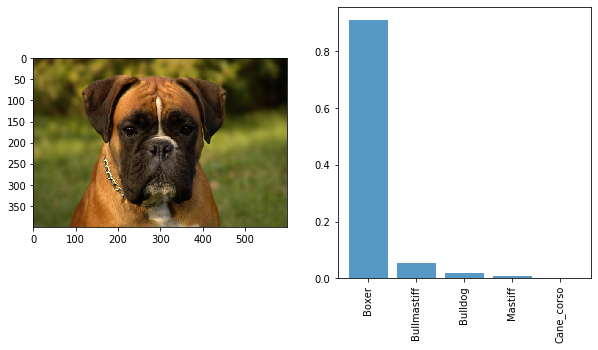

In [260]:
import os, random
src = 'C:/Users/Jesse/Documents/PyData/DSND_t2_capstone/dog-project/dogImages/test'
folder = random.choice(os.listdir(src))
file = random.choice(os.listdir(src+'/'+folder))
fullpath = '/'.join([src, folder, file])

final_predict(fullpath, topk = 5)

print(fullpath.split('/')[-2].split('.')[-1])

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [263]:
# Write algorithm for image processing pipeline

def full_image_process(img_path, topk = 5):
    dog_present = False
    human_present = False
    
    # detect dog
    if dog_detector(img_path):
        print('Dog found!')
        dog_present = True
        
    # detect human    
    elif face_detector(img_path):
        human_present = True
        print('Human found!')
        print('You look like a:')
    
    # if one: match with dog
    if dog_present or human_present:
        final_predict(img_path, topk = topk)
        
    # if neither, output error
    else:
        print('No human or dog detected')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Dog found!


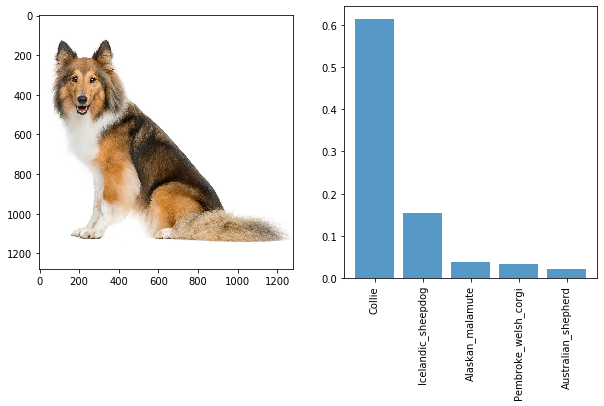

In [265]:
fullpath = 'C:/Users/Jesse/Pictures/shetland-sheepdog.jpg'
full_image_process(fullpath)

Human found!
You look like a:


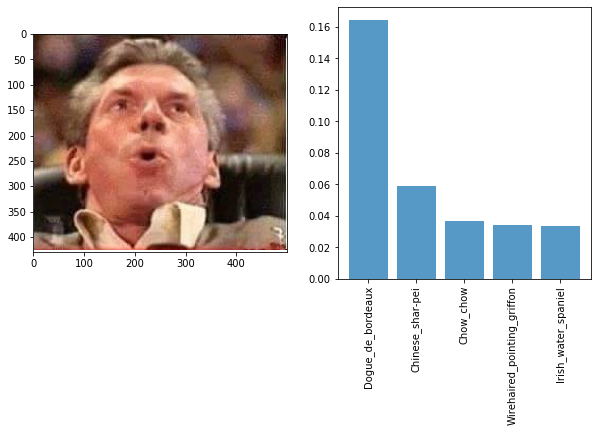

In [266]:
fullpath = 'C:/Users/Jesse/Pictures/comboburst_vm-2.png'
full_image_process(fullpath)

In [270]:
fullpath = 'C:/Users/Jesse/Pictures/cat.jpg'
full_image_process(fullpath)

No human or dog detected


Dog found!


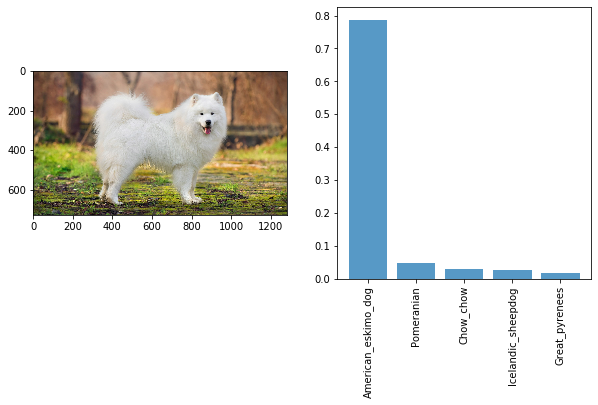

In [271]:
fullpath = 'C:/Users/Jesse/Pictures/Sammoyed.jpg'
full_image_process(fullpath)

Human found!
You look like a:


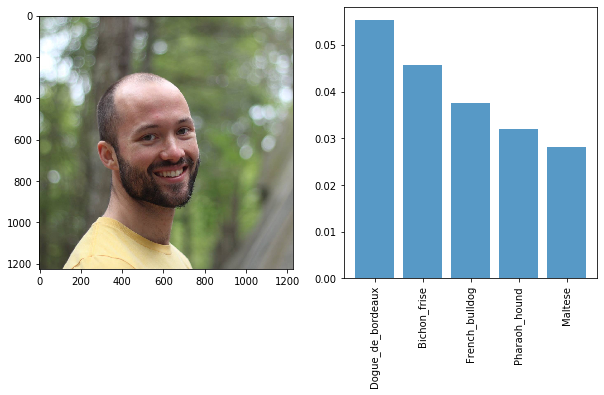

In [272]:
fullpath = 'C:/Users/Jesse/Pictures/13350418_10208198628915224_1099927911405740637_o.jpg'
full_image_process(fullpath)

Dog found!


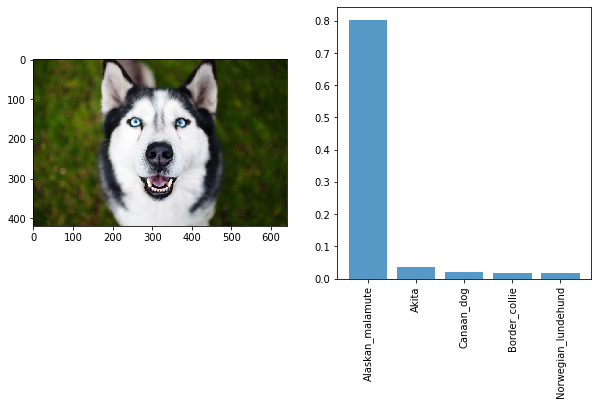

In [273]:
fullpath = 'C:/Users/Jesse/Pictures/husky.jpg'
full_image_process(fullpath)

In [276]:
final_model.layers[0].layers